let us start by importing the required functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
# from ema_workbench.em_framework
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors import vensimDLLwrapper
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

NOTE: I decided not to do scenario discovery at this early phase. scenario discovery at this phase sometimes creates conflicting subspaces for different objectives, and some are not even relevant to land use policy, e.g. directly pointing to immigration rate and fertility rate. So, the idea now is to follow the basic mordm structure. we optimize current land use options available for the objectives through the evolutionary algorithm (since the context is land use policy), do uncertainty analysis, and then do scenario discovery AFTERWARDS by lowering the objective threshold to optimize further. Because the current robustness structure is minimax/maximin. This further optimization can link to other non land use policies, and it is fine because it can pinpoint the fundamental reason of these options to emerge, such as disparity of development between Jakarta and any other cities which cause high immigration rate. 

What we can do after that is to either motivate the PRIM result with text (like Bramka did), to integrate the scenario discovery result to the model and run again, or to design pathways combining the scenario discovery insights. I personally prefer the first option because i dont have time. But if you want to you can do the latter options it is fine. BUT please do not change the current structure for both model and script. Improve it from the last step of this page.

## Integrated without levers 

In [2]:
vensimModel = VensimModel("BaseCase", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_Base.vpm" )

In [3]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
            RealParameter("PopFracExtensive", 0, 1),
            RealParameter("PopFracInteg", 0, 1),    
            RealParameter("reductionSalinity", 0.05, 0.35),
            RealParameter("IncreasedSediment", 0.05 , 0.35),
            RealParameter("reducedegradation", 0.05 , 0.35),
            RealParameter("Ricecostreduce", 0.05 , 0.35),
            RealParameter("Treatment Rate", 0.003 , 0.01)
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

policies = [
            Policy('no_pol',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_NoPolicy.vpm"),
            Policy('Wtr_treat',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_WaterTreatmentPolicy.vpm"),
            Policy('integ_promo',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_IntegratedSubsidyPolicy.vpm"),
            Policy('info_prog',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_InformationProgramPolicy.vpm"),
            Policy('Eco_rice',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_EcoRicePolicy.vpm"),
             Policy('Dikes',
                    model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_DikesPolicy.vpm")
           ]



In [4]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS, policies= policies)

[MainProcess/INFO] performing 100 scenarios * 6 policies * 1 model(s) = 600 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] experiments finished


In [5]:
results_name = './BenTre_SD_AllPolicies_individual_100_lhs_nolevers.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_AllPolicies_individual_100_lhs_nolevers.tar.gz


In [8]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

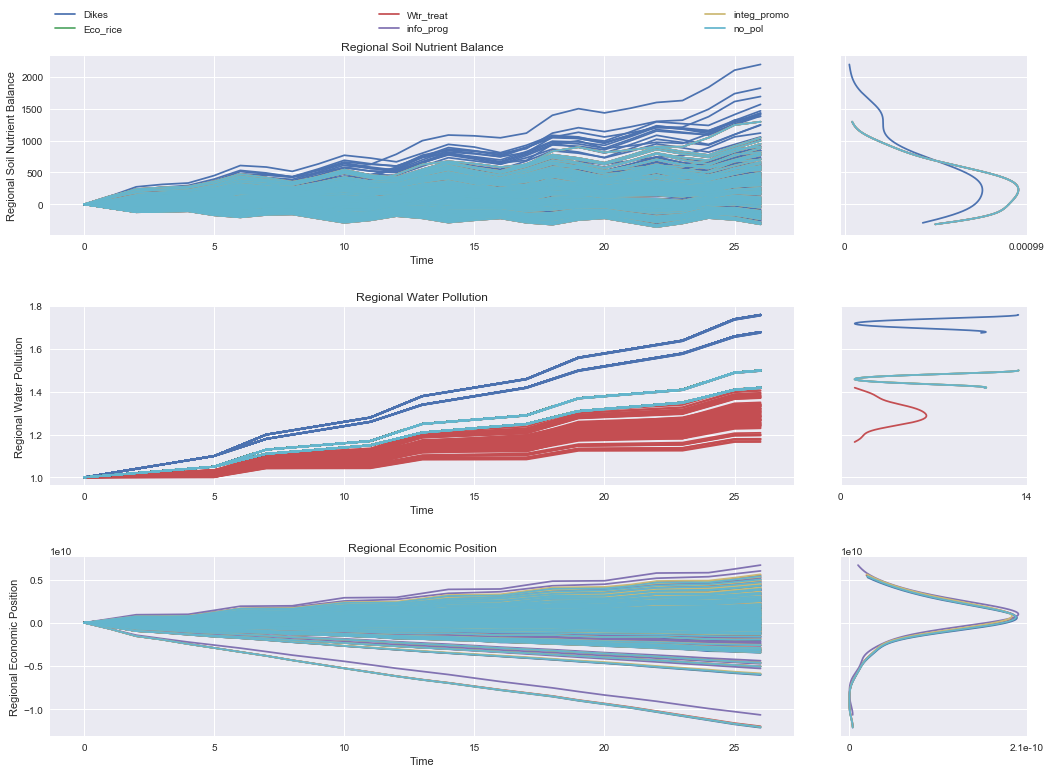

In [9]:
figure = emaplt.lines(results, group_by ='policy', density=u'kde') #show lines, and end state density
# plt.rcParams["figure.figsize"] = (15,30)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], group_by ='policy', density=KDE)
plt.show()

In [8]:
# figure = lines(results,density=u'kde') #show lines, and end state density
# plt.show() #show figure

In [92]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand_up.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand_up.tar.gz


In [6]:
import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE
import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt

In [97]:
plt.rcParams["figure.figsize"] = (20,7.5)

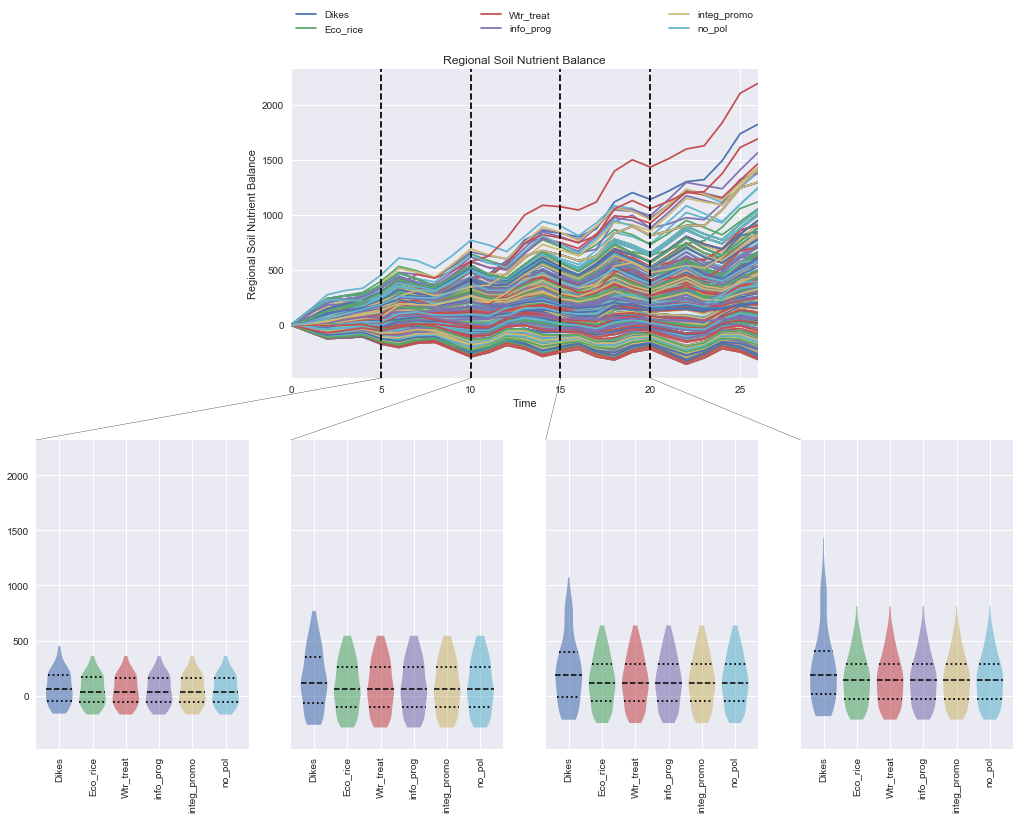

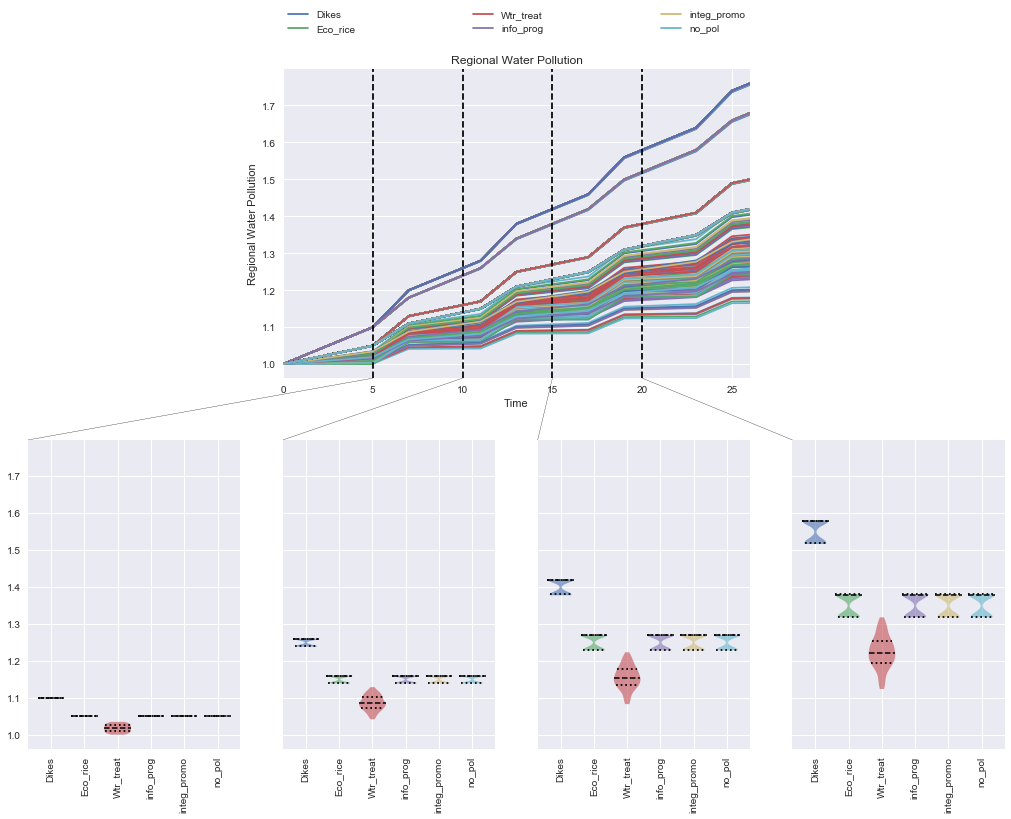

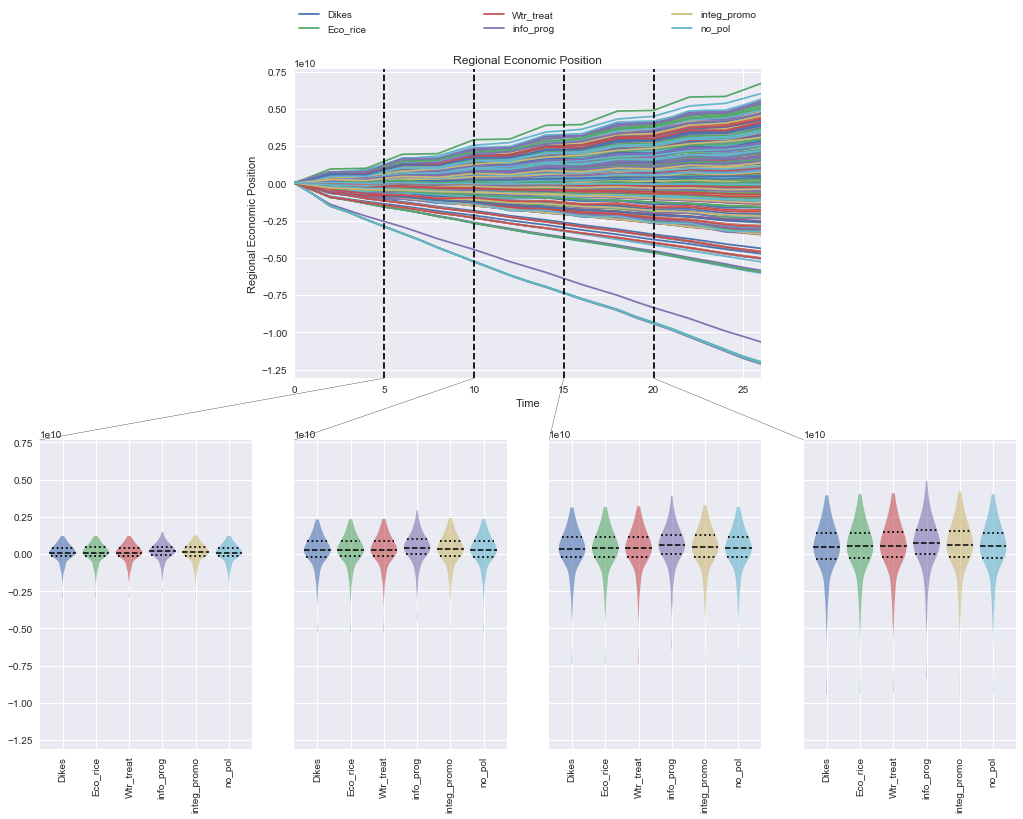

In [10]:
fig = emaplt.multiple_densities(results, points_in_time=[5, 10, 15, 20], 
                                outcomes_to_show=['Regional Soil Nutrient Balance','Regional Water Pollution','Regional Economic Position'], group_by ='policy', density=u'violin', plot_type = 'lines')
# plt.rcParams["figure.figsize"] = (5,15)
plt.show()

## Integrated with levers large 

In [8]:
vensimModel = VensimModel("BaseCase", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_NoPolicy.vpm" )

In [9]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.4),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.5),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
            RealParameter("PopFracExtensive", 0, 1),
            RealParameter("PopFracInteg", 0, 1)    
]

vensimModel.levers = [
            RealParameter("reductionSalinity", 0.05, 0.95),
            RealParameter("IncreasedSediment", 0.05 , 0.95),
            RealParameter("reducedegradation", 0.05 , 0.95),
            RealParameter("Ricecostreduce", 0.05 , 0.95),
            RealParameter("Treatment Rate", 0.003 , 0.0095)
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

policies = [
            Policy('no_pol',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_NoPolicy.vpm"),
            Policy('Wtr_treat',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_WaterTreatmentPolicy.vpm"),
            Policy('integ_promo',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_IntegratedSubsidyPolicy.vpm"),
            Policy('info_prog',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_InformationProgramPolicy.vpm"),
            Policy('Eco_rice',
                   model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_EcoRicePolicy.vpm"),
            Policy('Dikes',
                    model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_DikesPolicy.vpm"),
            Policy('All',
                    model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\Step2_BenTre_SD_AllPolicy.vpm")
           ]



In [10]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS, policies= policies, levers_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 7 policies * 1 model(s) = 700 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 490 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 630 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] experiments finished


In [11]:
results_name = './BenTre_SD_AllPolicies_individual_100_lhs_large.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_AllPolicies_individual_100_lhs_large.tar.gz


In [12]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

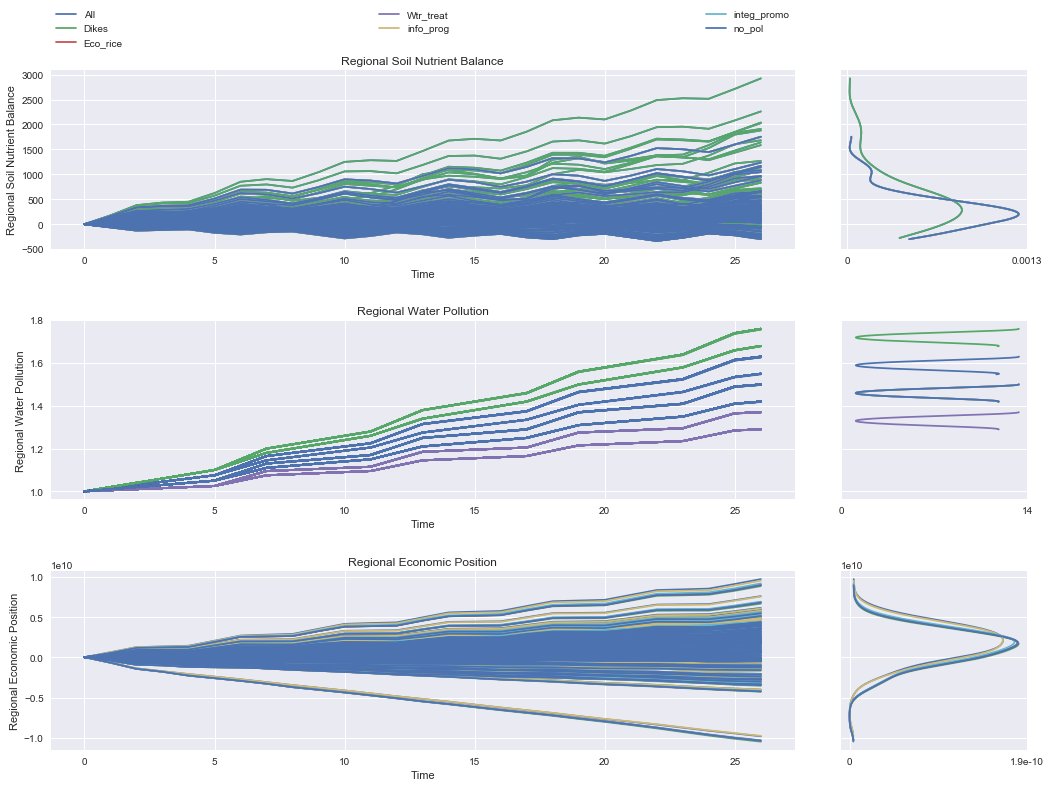

In [13]:
figure = emaplt.lines(results, group_by ='policy', density=u'kde') #show lines, and end state density
# plt.rcParams["figure.figsize"] = (15,30)
plt.show()

In [3]:
plt.rcParams["figure.figsize"] = (10,7)

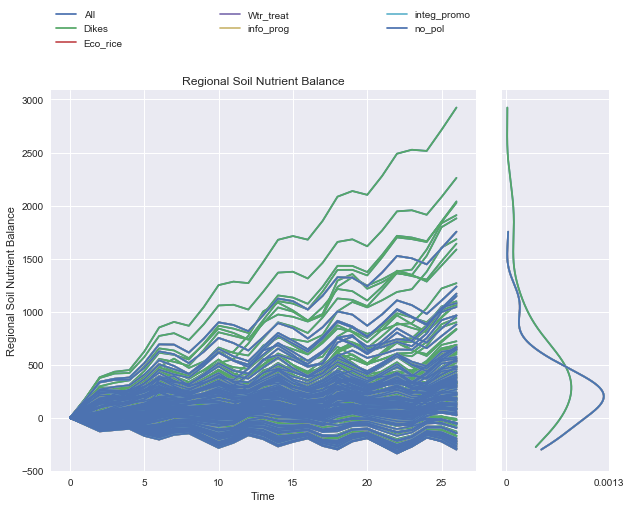

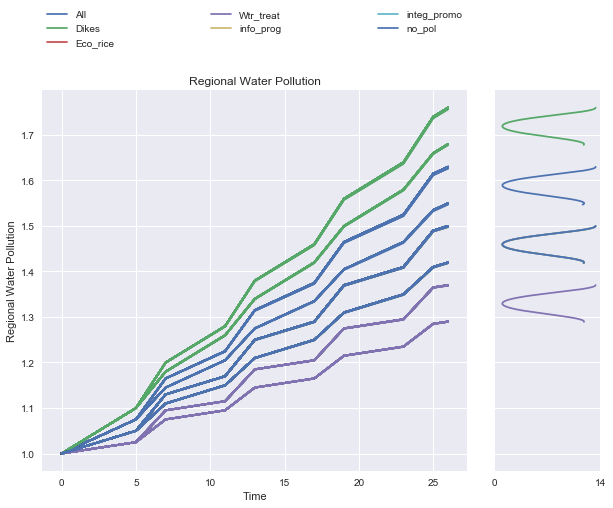

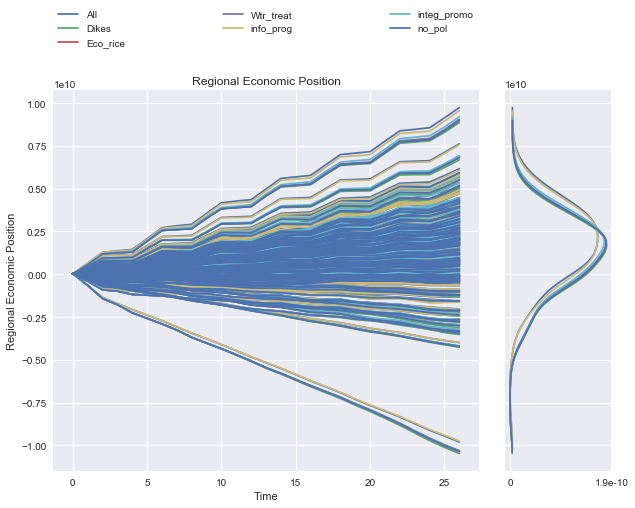

In [4]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], group_by ='policy', density=KDE)
plt.show()

In [8]:
# figure = lines(results,density=u'kde') #show lines, and end state density
# plt.show() #show figure

In [2]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_AllPolicies_individual_100_lhs_large.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_AllPolicies_individual_100_lhs_large.tar.gz


In [2]:
import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE
import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt

In [15]:
plt.rcParams["figure.figsize"] = (20,7.5)

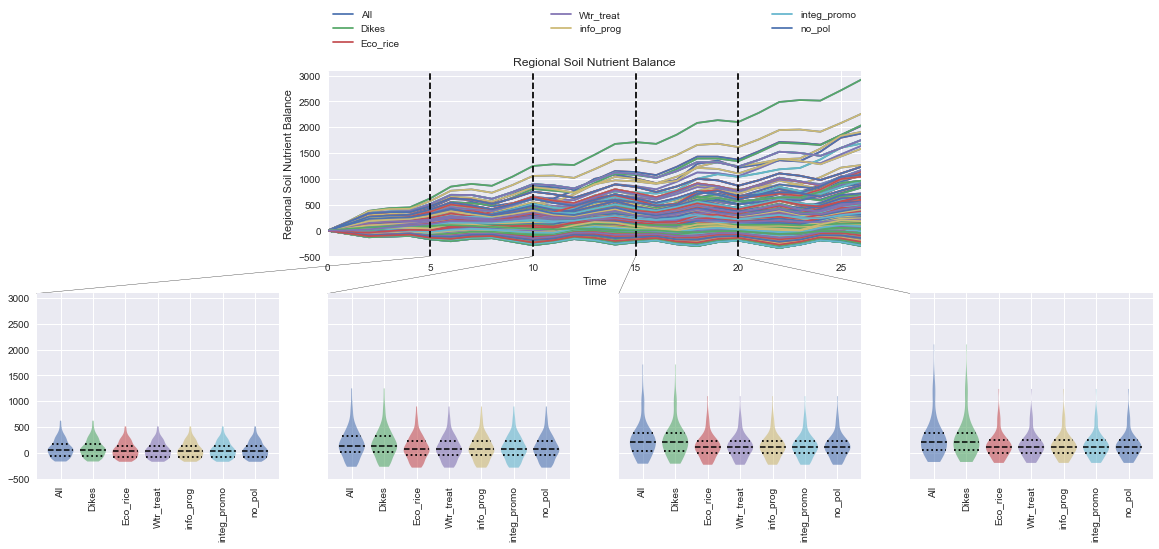

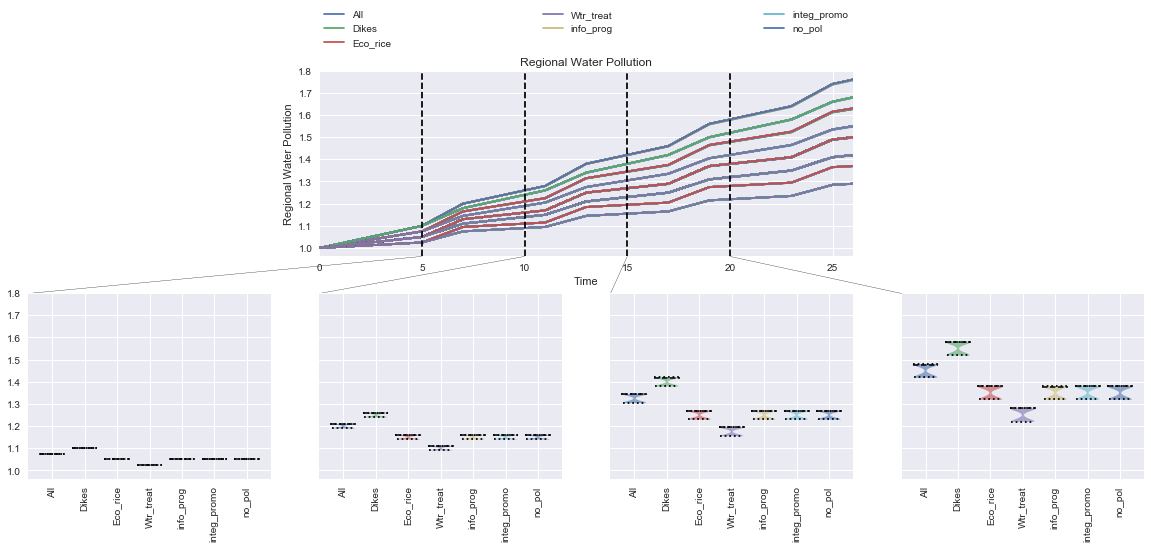

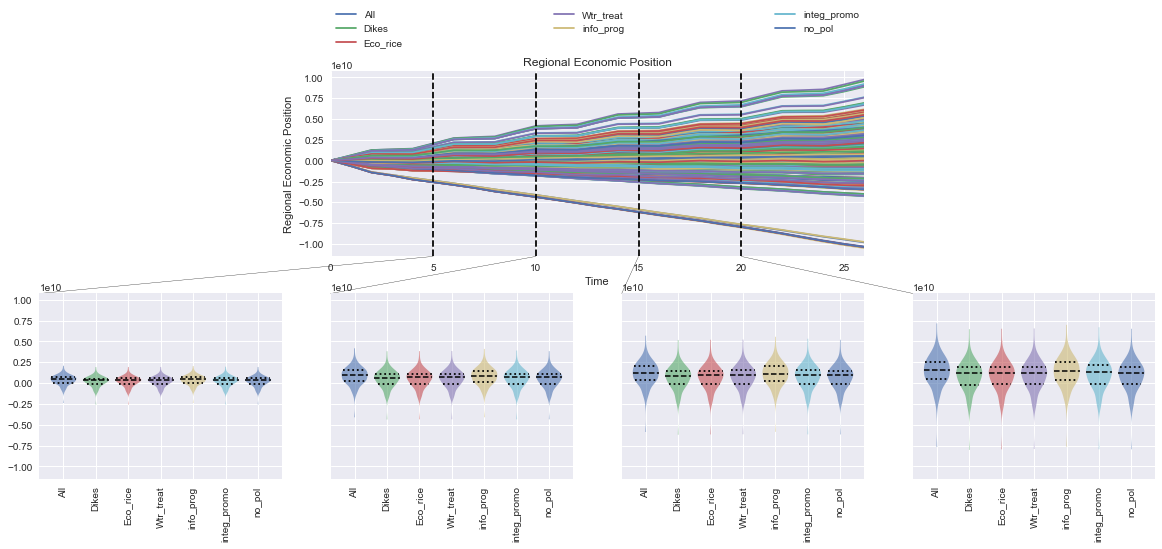

In [16]:
fig = emaplt.multiple_densities(results, points_in_time=[5, 10, 15, 20], 
                                outcomes_to_show=['Regional Soil Nutrient Balance','Regional Water Pollution','Regional Economic Position'], group_by ='policy', density=u'violin', plot_type = 'lines')
# plt.rcParams["figure.figsize"] = (5,15)
plt.show()

In [3]:
experiments, outcomes= results

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 700 points remaining, containing 185 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.15, coverage: 0.5675675675675675, density: 1.0 restricted_dimensions: 16


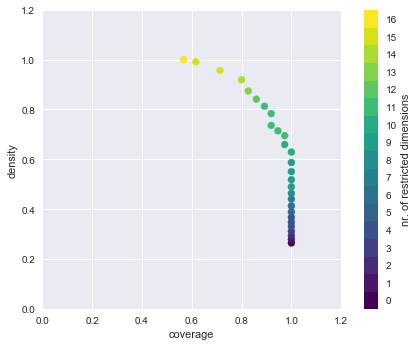

In [5]:
box_1.show_tradeoff()
# mpld3.display()

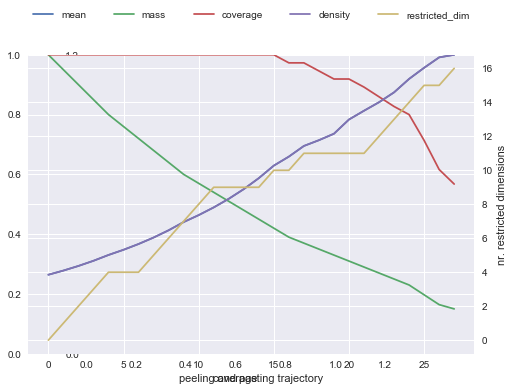

In [6]:
box_1.show_ppt()
plt.show()

coverage    0.918919
density      0.78341
mass            0.31
mean         0.78341
res dim           11
Name: 20, dtype: object

                                                box 20                \
                                                   min           max   
Extensive Shrimp Survival Rate                0.101339      0.421379   
Extensive Shrimp Recruitment per hectare  75083.630541  98504.416551   
FertStartPrice                                3.206387      6.981121   
PopFracExtensive                              0.002950      0.942557   
SedNutContent                               273.371187    329.951518   
RicePriceChngRate                             1.000093      1.002564   
ExogNutAvailRate                              8.366539     14.742589   
CostFresh                                     0.518975      0.784968   
FertPriceChngRate                             1.010174      1.048807   
Rate of Degradation                           1.303519      4.972447   
Dredgi

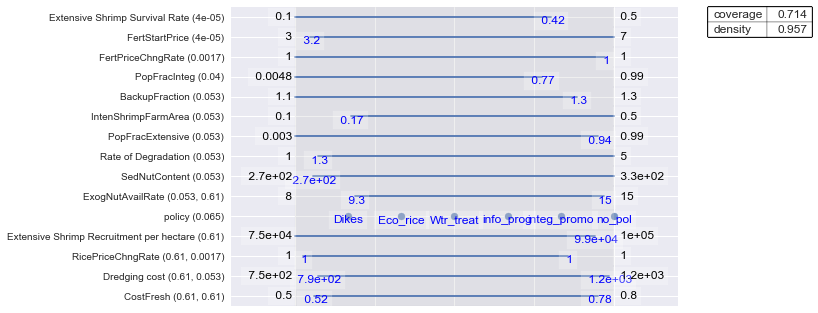

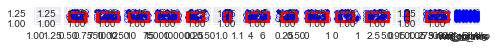

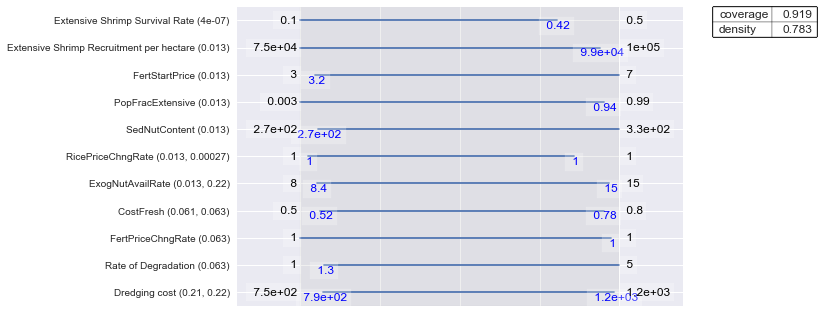

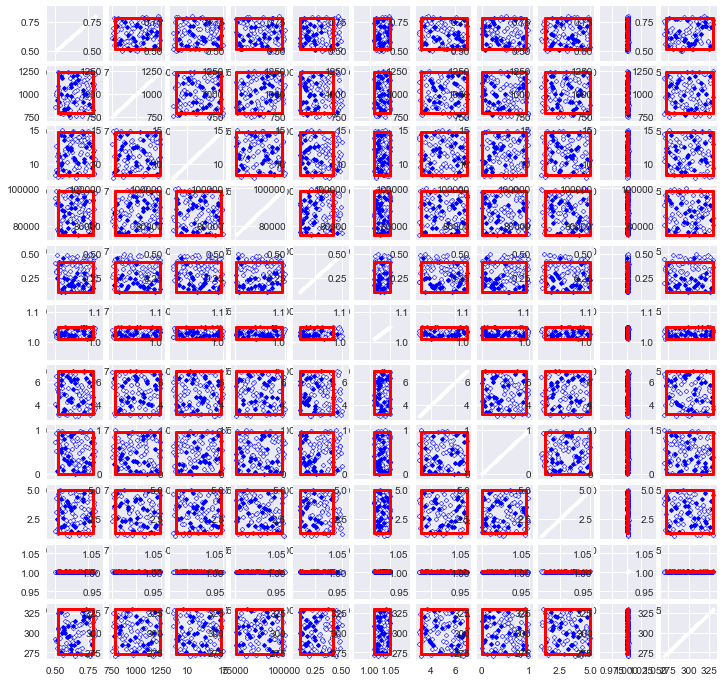

In [10]:
valuebox = 20
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [11]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.2575] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 700 points remaining, containing 200 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2857142857142857, coverage: 1.0, density: 1.0 restricted_dimensions: 1


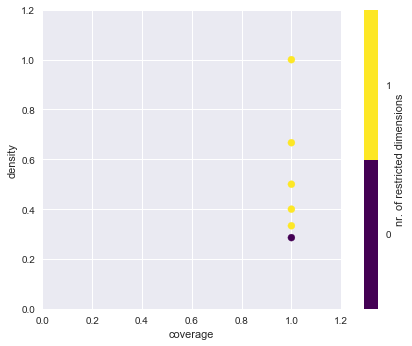

In [12]:
box_1.show_tradeoff()
# mpld3.display()

coverage           1
density          0.4
mass        0.714286
mean             0.4
res dim            1
Name: 2, dtype: object

                                               box 2  \
                                                 min   
policy  {All, Wtr_treat, Dikes, Eco_rice, info_prog}   

                                                                                
                                                 max                 qp values  
policy  {All, Wtr_treat, Dikes, Eco_rice, info_prog}  [2.7485701032039884e-08]  



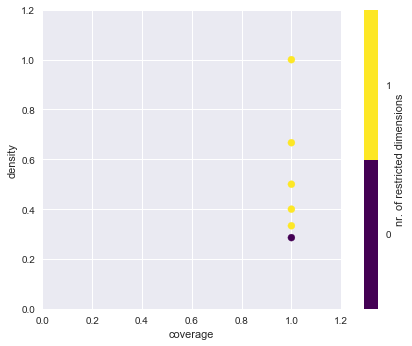

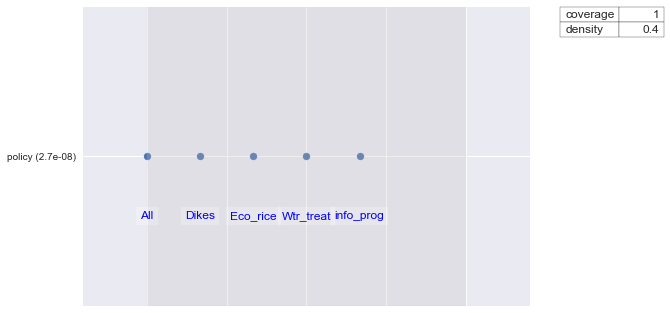

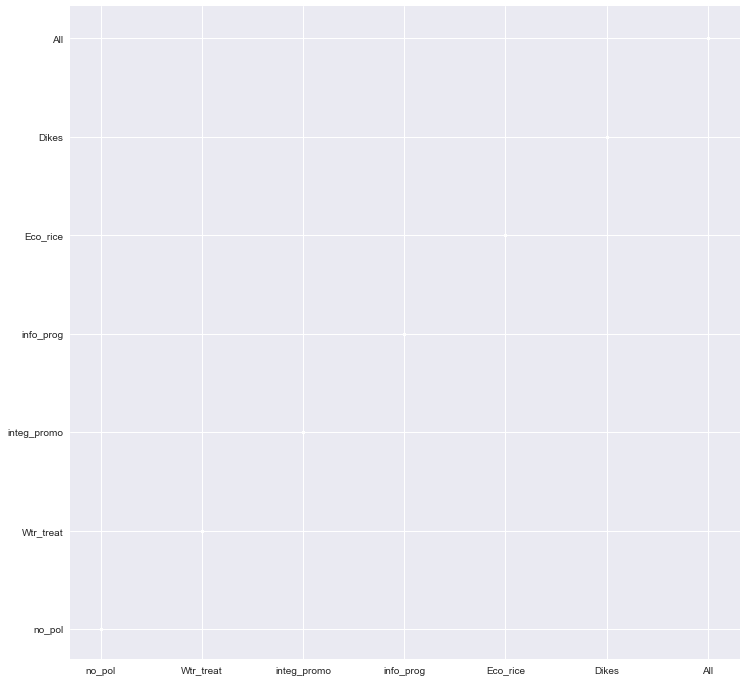

In [13]:
valuebox = 2
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [14]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<100] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 700 points remaining, containing 324 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.27, coverage: 0.5833333333333334, density: 1.0 restricted_dimensions: 9


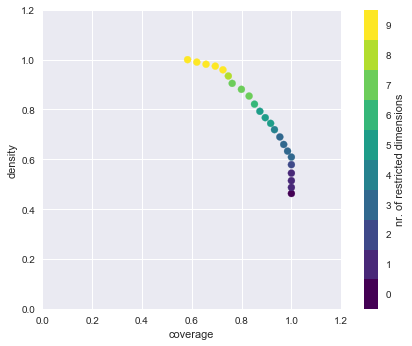

In [15]:
box_2.show_tradeoff()
# mpld3.display()

coverage    0.830247
density     0.853968
mass            0.45
mean        0.853968
res dim            7
Name: 14, dtype: object

                                  box 14            \
                                     min       max   
FloodDuration                   0.103579  0.823577   
TimeToNutAvailable              3.334544  9.971721   
CostIntense                     0.700274  0.977863   
RiceStartPrice                  3.004161  8.696197   
Extensive Shrimp Survival Rate  0.127959  0.499757   
FertStartPrice                  3.019731  6.730482   
Intensive Shrimp Survival Rate  0.717972  0.968114   

                                                                               
                                                                    qp values  
FloodDuration                                        [6.1128277633967767e-12]  
TimeToNutAvailable                                   [3.4975065473325966e-08]  
CostIntense                                           [0.001994

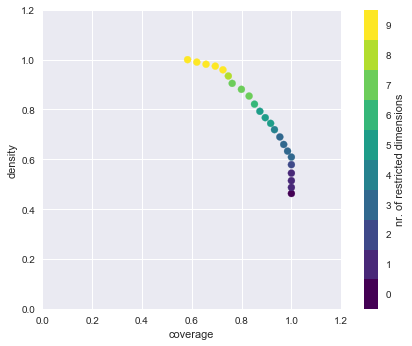

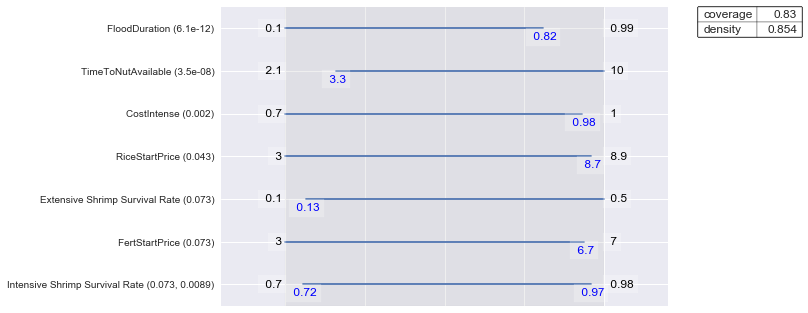

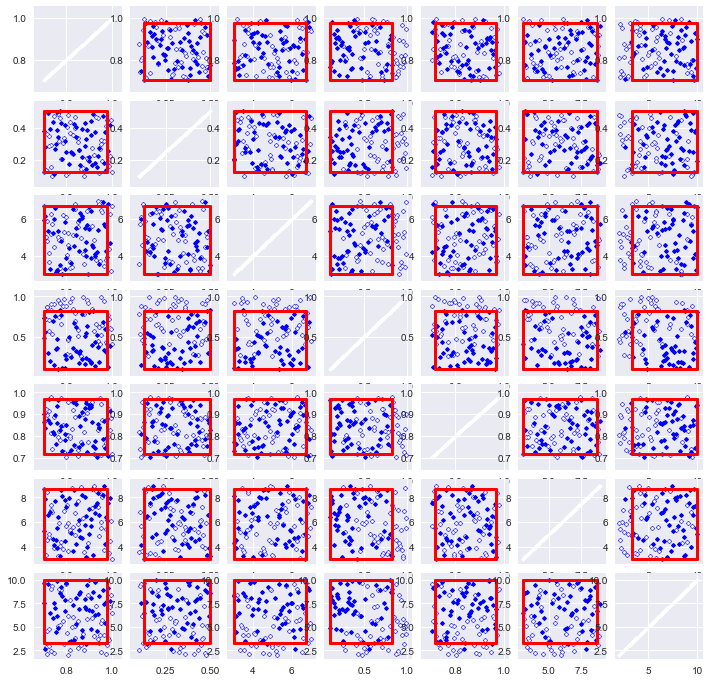

In [16]:
valuebox = 14
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

# Binh Dai

In [4]:
vensimModel = VensimModel("BaseCaseBinh", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand_up.vpm" )

In [5]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
            RealParameter("PopFracExtensive", 0, 1),
#             RealParameter("PopFracInteg", 0, 0.5)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [6]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [7]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand_up.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand_up.tar.gz


In [8]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

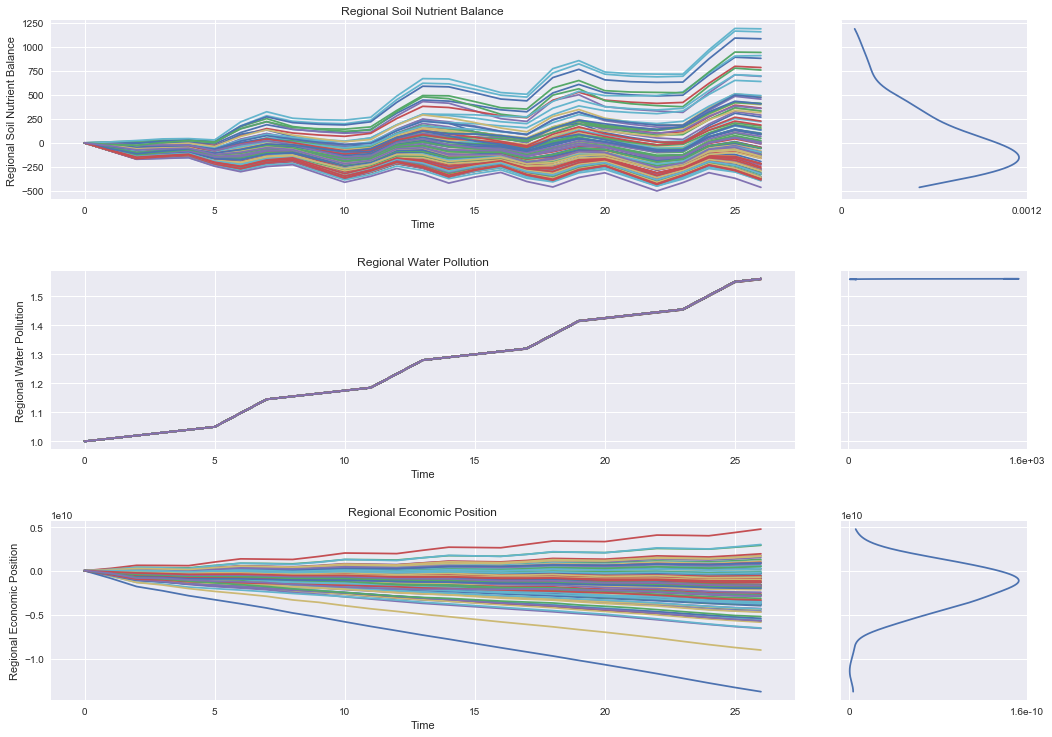

In [9]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [92]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand_up.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand_up.tar.gz


In [93]:
import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE
import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt

In [97]:
plt.rcParams["figure.figsize"] = (20,7.5)

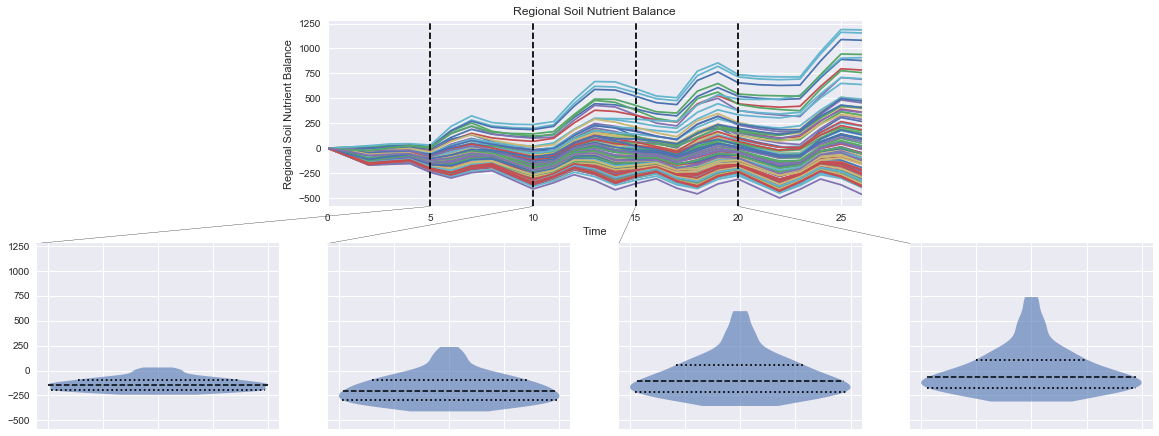

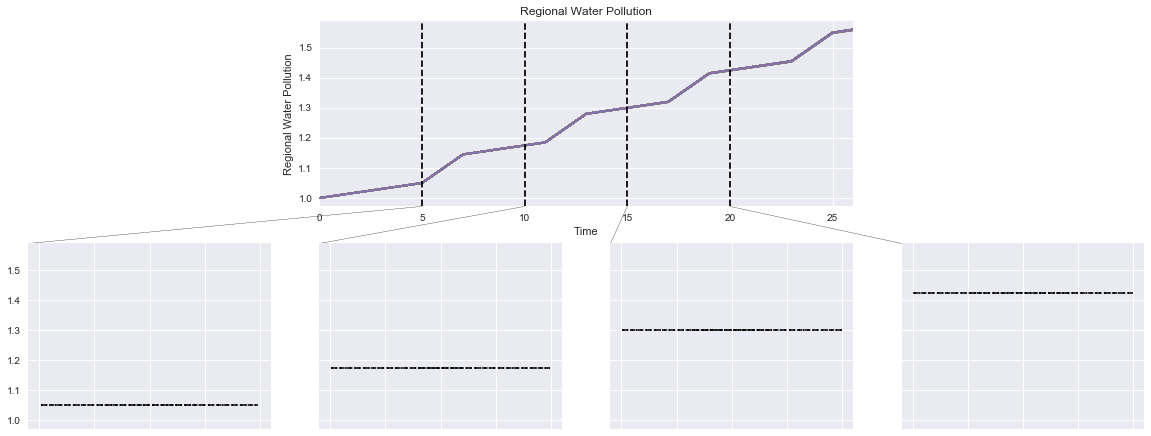

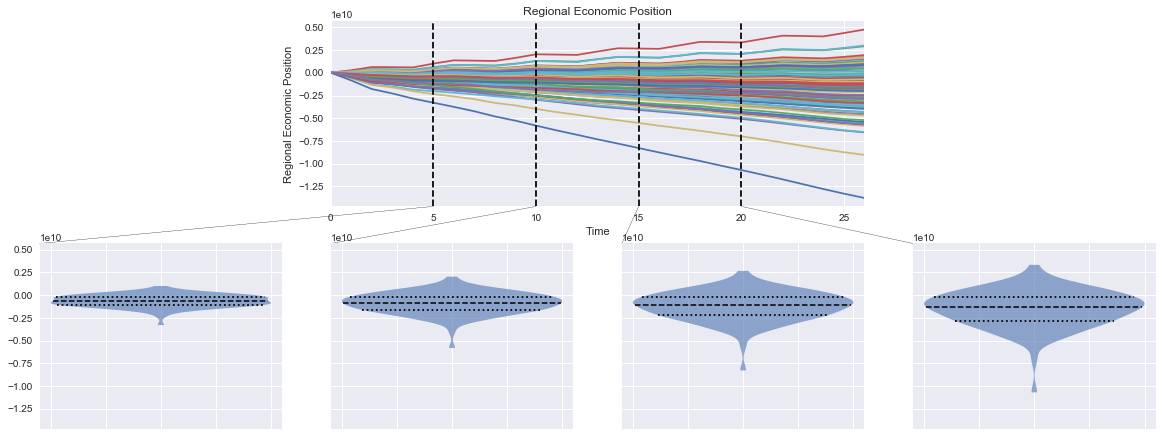

In [98]:
fig = emaplt.multiple_densities(results, points_in_time=[5, 10, 15, 20], 
                                outcomes_to_show=['Regional Soil Nutrient Balance','Regional Water Pollution','Regional Economic Position'], density=u'violin', plot_type = 'lines')
# plt.rcParams["figure.figsize"] = (5,15)
plt.show()

In [3]:
# outputs = list(results[1].keys())[1:] 

# for x in outputs:
#     fig = lines(results, outcomes_to_show=[x], density=KDE)
# plt.show()

In [4]:
experiments, outcomes= results

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 77 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.64, coverage: 0.8311688311688312, density: 1.0 restricted_dimensions: 6


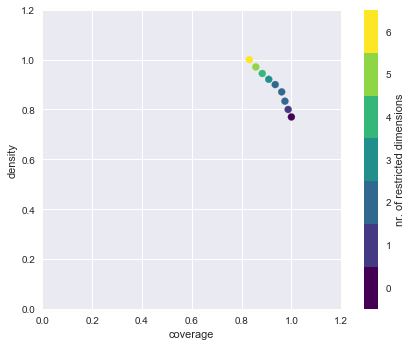

In [18]:
box_1.show_tradeoff()
# mpld3.display()

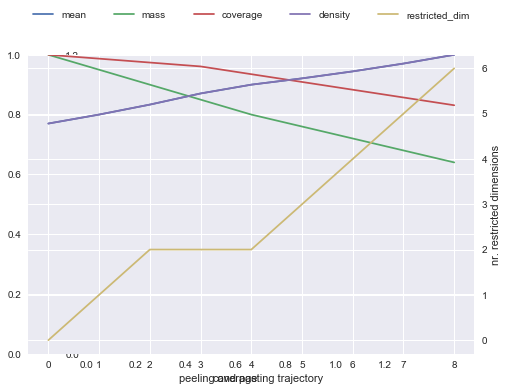

In [7]:
box_1.show_ppt()
plt.show()

coverage    0.831169
density            1
mass            0.64
mean               1
res dim            6
Name: 8, dtype: object

                                                  box 8                \
                                                    min           max   
PopFracExtensive                               0.009303      0.835541   
Extense Selling                                3.027277      7.751989   
Freshwater Shrimp Recruitment per hectare  10663.697447  24949.476503   
IntenShrimpFarmArea                            0.101411      0.483487   
MinWage                                     5198.146835   9989.241915   
Salinity Rate                                  0.010627      0.096212   

                                                                     
                                                          qp values  
PopFracExtensive                           [6.7988673922874578e-05]  
Extense Selling                               [0.14376972839666999]  
Freshw

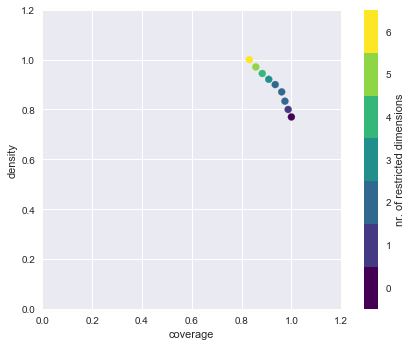

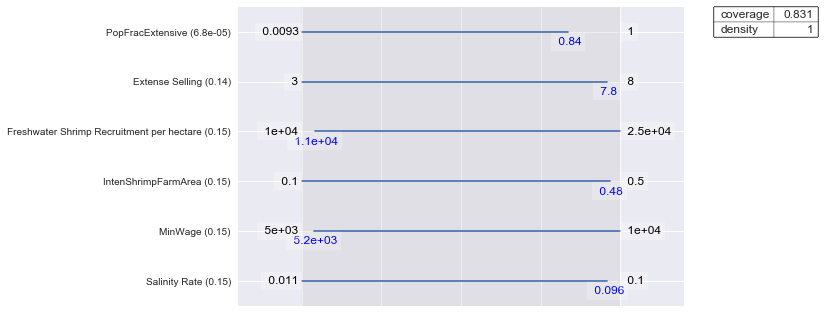

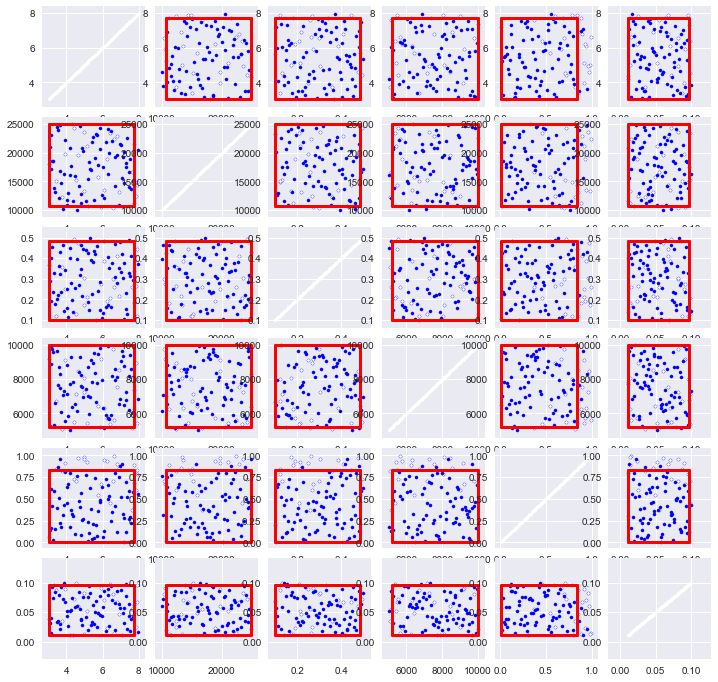

In [19]:
valuebox = 8
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>-1] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 23 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.23, coverage: 1.0, density: 1.0 restricted_dimensions: 16


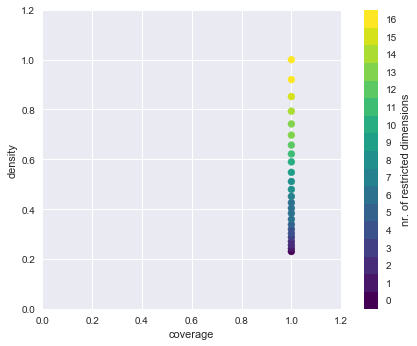

In [11]:
box_1.show_tradeoff()

coverage           1
density     0.547619
mass            0.42
mean        0.547619
res dim            9
Name: 15, dtype: object

                                                box 15                \
                                                   min           max   
Extensive Shrimp Recruitment per hectare  81220.505922  99882.371732   
Extensive Shrimp Survival Rate                0.147267      0.398355   
ExogNutAvailRate                              8.029389     14.375175   
FertPriceChngRate                             1.014517      1.049842   
CostIntense                                   0.709907      0.999284   
Extense Selling                               3.341518      7.955336   
BaseTE                                        0.257995      0.399400   
CostRiceUnit                                  1.353802      7.997448   
CostFresh                                     0.514709      0.784116   

                                                                             

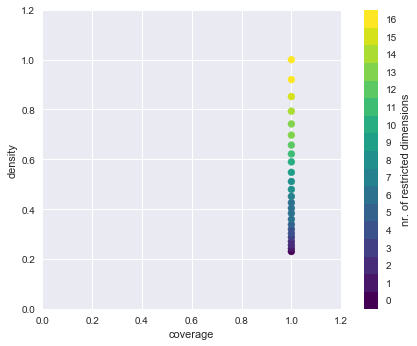

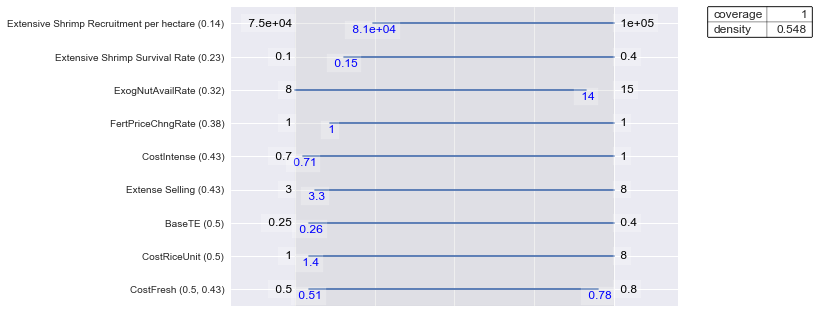

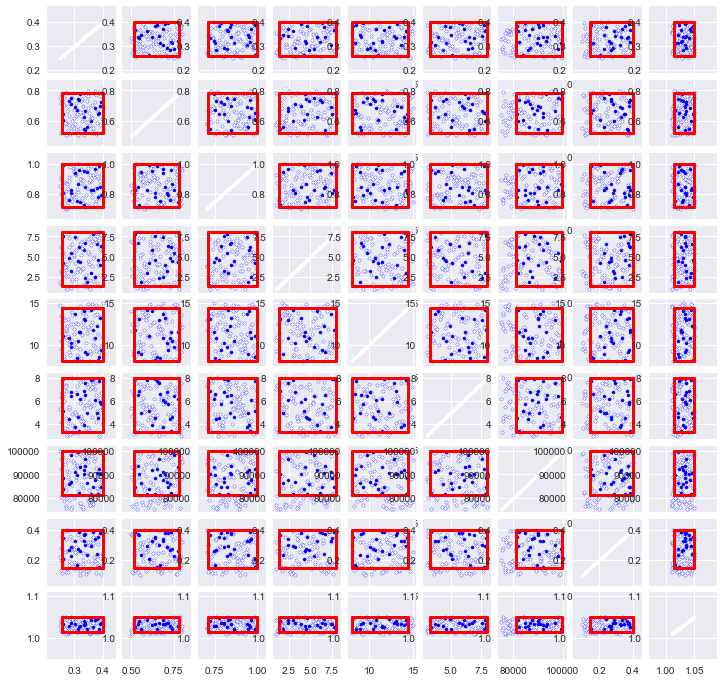

In [16]:
valuebox = 15
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

### Market Saturation is pushing down intesive shrimp prices

if continued, it will be harmful

In [33]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.2575] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 75 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.48, coverage: 0.64, density: 1.0 restricted_dimensions: 6


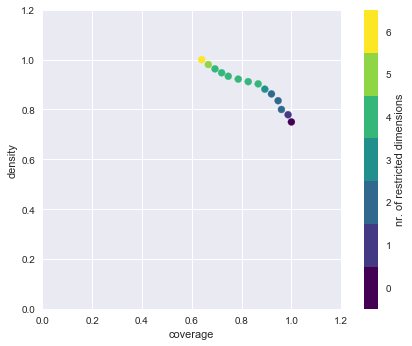

In [34]:
box_1.show_tradeoff()
# mpld3.display()

coverage    0.666667
density     0.980392
mass            0.51
mean        0.980392
res dim            5
Name: 12, dtype: object

                                    box 12               \
                                       min          max   
Extensive Shrimp Survival Rate    0.171150     0.398355   
Extense Selling                   3.732592     7.788541   
BackupFraction                    1.050886     1.287847   
Intensive Shrimp Survival Rate    0.701582     0.968165   
Dredging cost                   777.062321  1245.897775   

                                                                           
                                                                qp values  
Extensive Shrimp Survival Rate                    [0.0013389880795745728]  
Extense Selling                 [0.06664727527926198, 0.4422094447093321]  
BackupFraction                                      [0.22564404609183919]  
Intensive Shrimp Survival Rate                      [0.22564404609183919]  


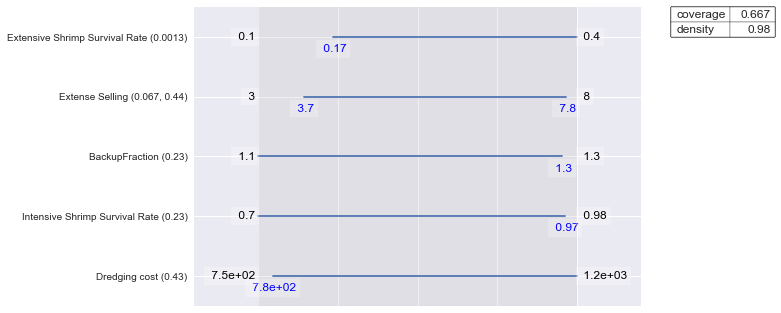

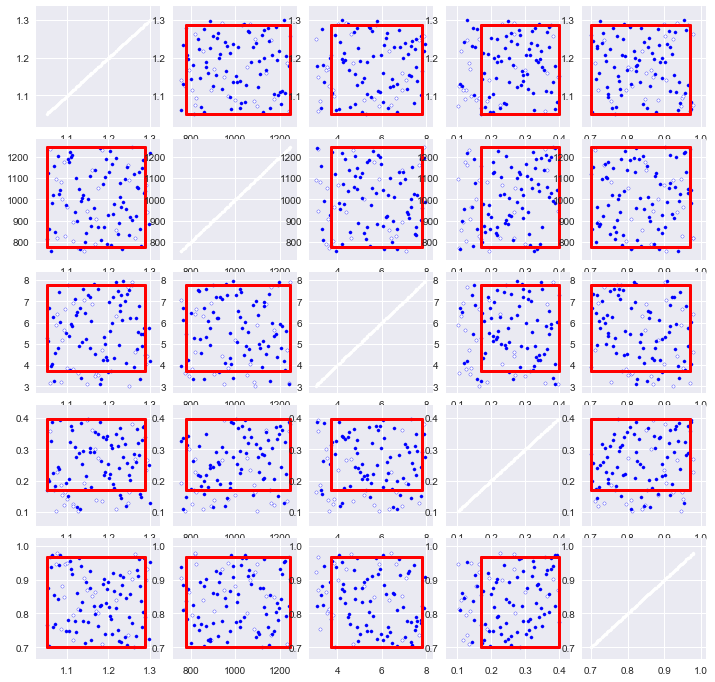

In [38]:
valuebox = 12
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [41]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<100] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 85 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.68, coverage: 0.8, density: 1.0 restricted_dimensions: 3


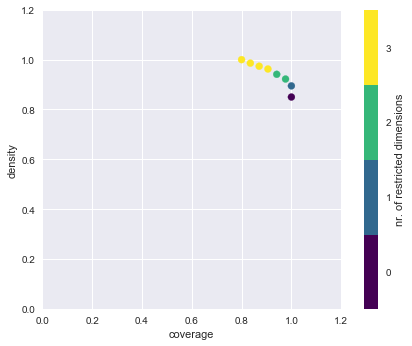

In [42]:
box_2.show_tradeoff()
# mpld3.display()

coverage    0.905882
density       0.9625
mass             0.8
mean          0.9625
res dim            3
Name: 4, dtype: object

                      box 4                                  
                        min       max               qp values
FloodDuration      0.103159  0.909203  [0.017860076600172511]
FertPriceChngRate  1.011948  1.049842   [0.17542834147528552]
PopFracExtensive   0.051900  0.998047   [0.30063714119462775]



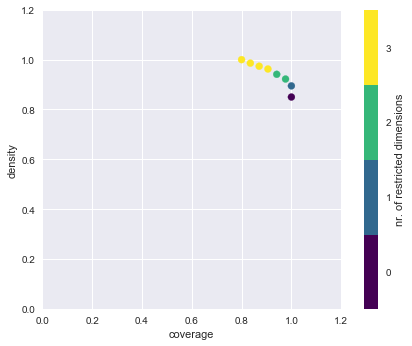

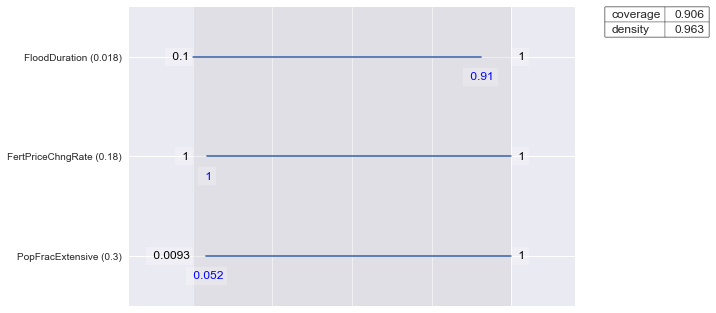

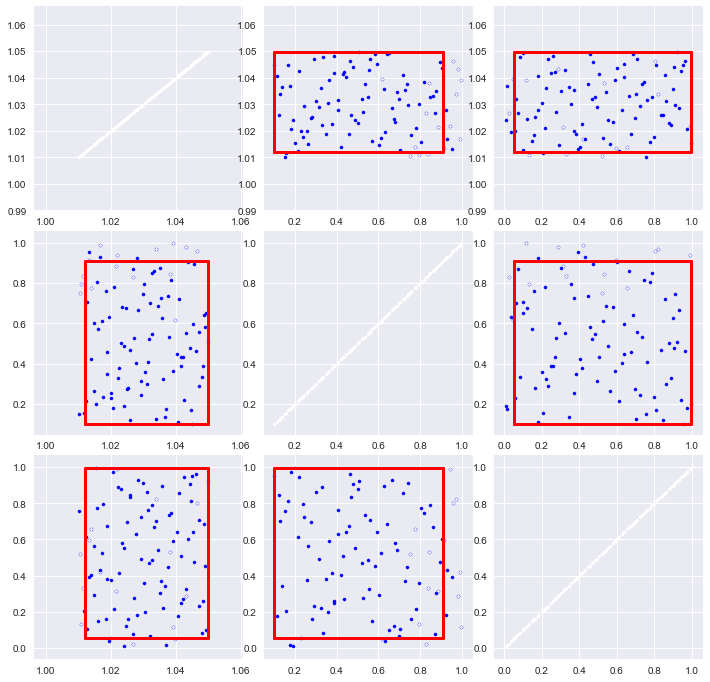

In [43]:
valuebox = 4
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

# Thanh Phu

In [10]:
vensimModel = VensimModel("BaseCaseThanh", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand_up.vpm" )

In [11]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
#             RealParameter("PopFracExtensive", 0, 0.5),
            RealParameter("PopFracInteg", 0, 1)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [12]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [13]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand_up.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand_up.tar.gz


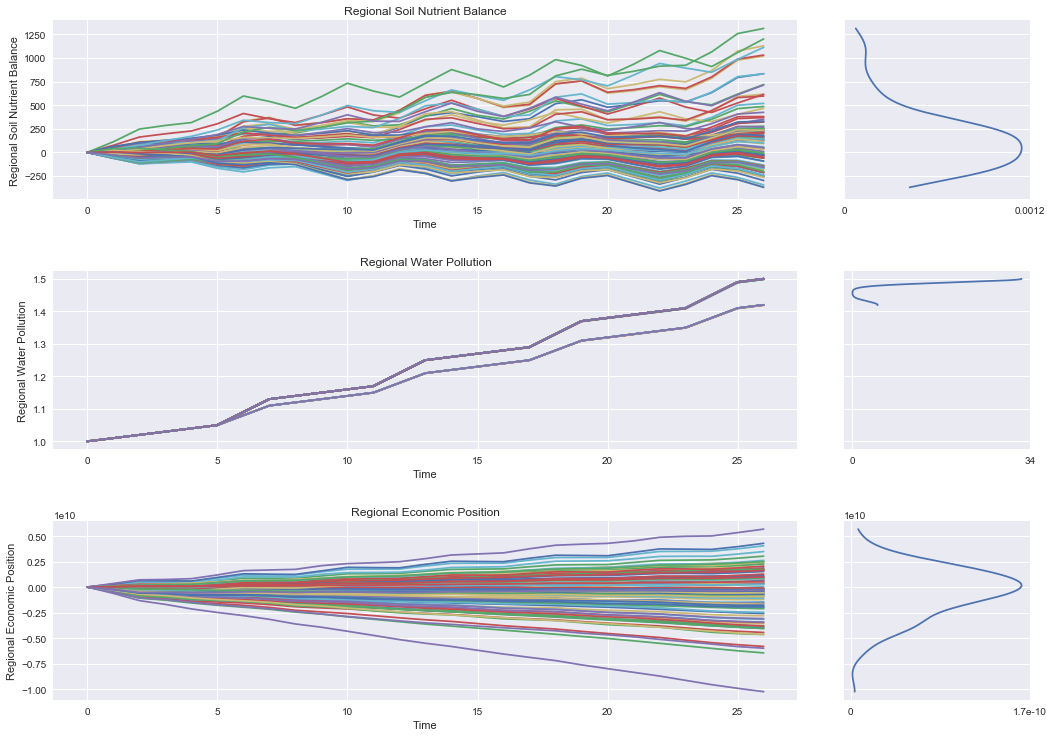

In [14]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [56]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

In [99]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand_up.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand_up.tar.gz


In [91]:
# outputs = list(results[1].keys())[1:] 

# for x in outputs:
#     fig = lines(results, outcomes_to_show=[x], density=KDE)
# plt.show()

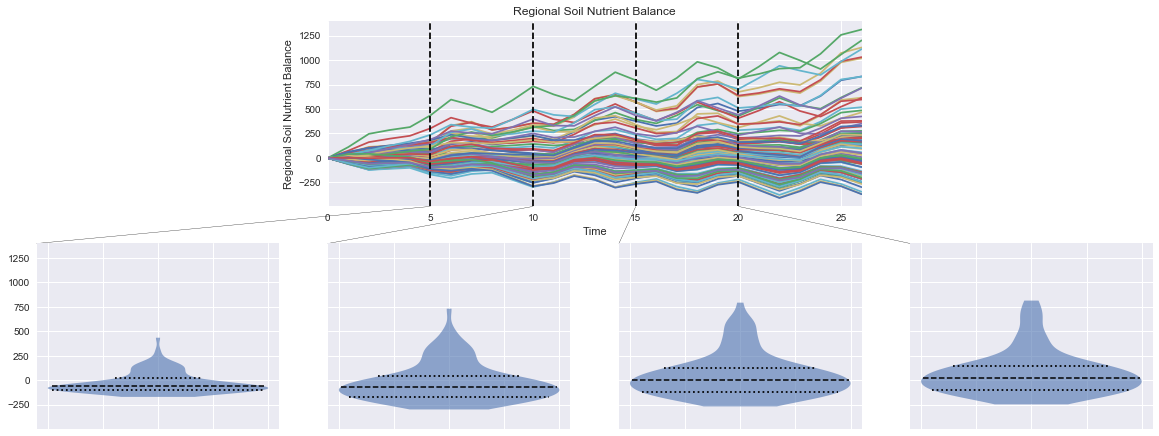

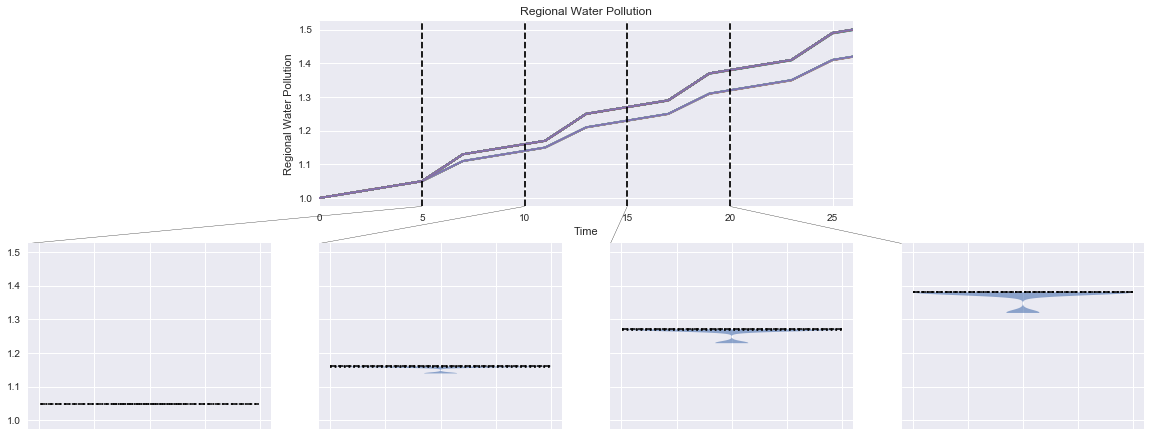

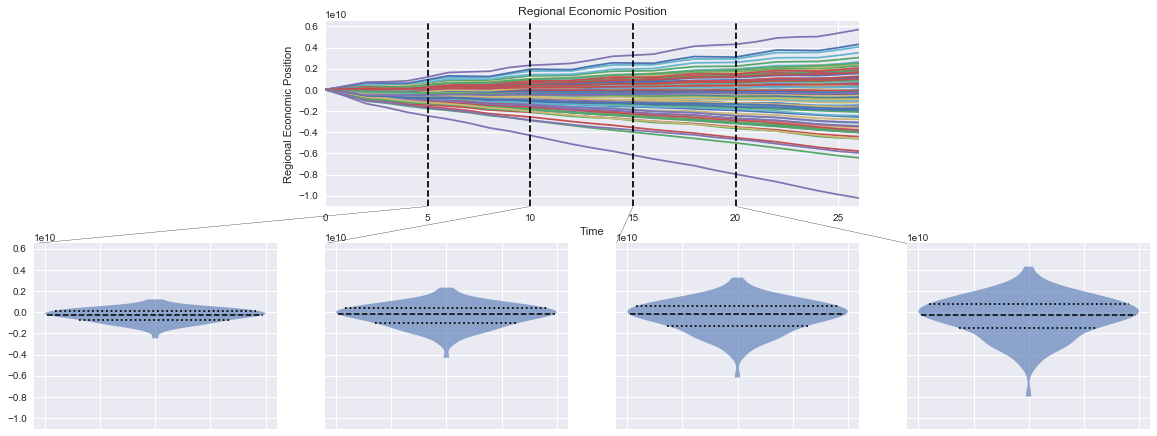

In [100]:
fig = emaplt.multiple_densities(results, points_in_time=[5, 10, 15, 20], 
                                outcomes_to_show=['Regional Soil Nutrient Balance','Regional Water Pollution','Regional Economic Position'], density=u'violin', plot_type = 'lines')
# plt.rcParams["figure.figsize"] = (5,15)
plt.show()

In [46]:
experiments, outcomes= results

In [47]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 56 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.37, coverage: 0.6607142857142857, density: 1.0 restricted_dimensions: 12


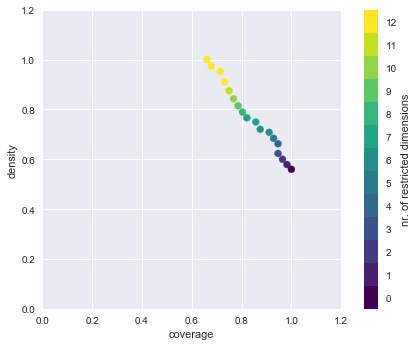

In [48]:
box_1.show_tradeoff()
# mpld3.display()

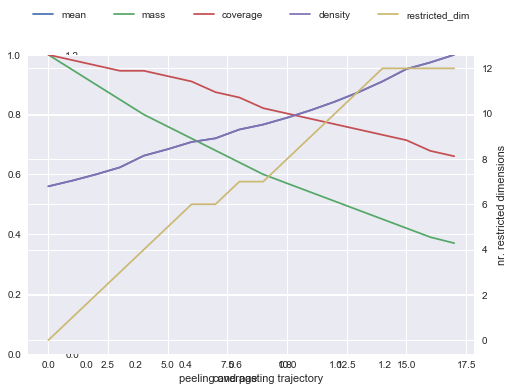

In [49]:
box_1.show_ppt()
plt.show()

coverage    0.714286
density     0.952381
mass            0.42
mean        0.952381
res dim           12
Name: 15, dtype: object

                                                box 15                \
                                                   min           max   
intenseSelling                                0.605027      1.170679   
crop survival probability                     0.069021      0.299023   
ExtShrimpFarmArea                             0.802460      1.179947   
Extensive Shrimp Recruitment per hectare  75989.245771  99898.891522   
CostExtense                                   0.030876      0.049874   
PopFracInteg                                  0.006704      0.919037   
RicePriceChngRate                             1.000207      1.002982   
Dredging cost                               774.986466   1223.957211   
BaseTE                                        0.263909      0.393564   
CostFresh                                     0.511255      0.797739   
Freshw

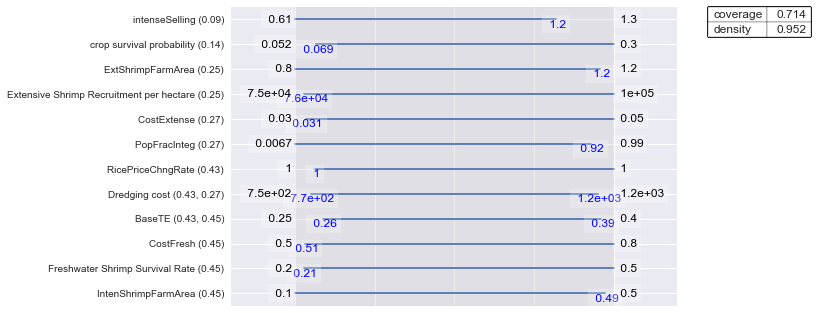

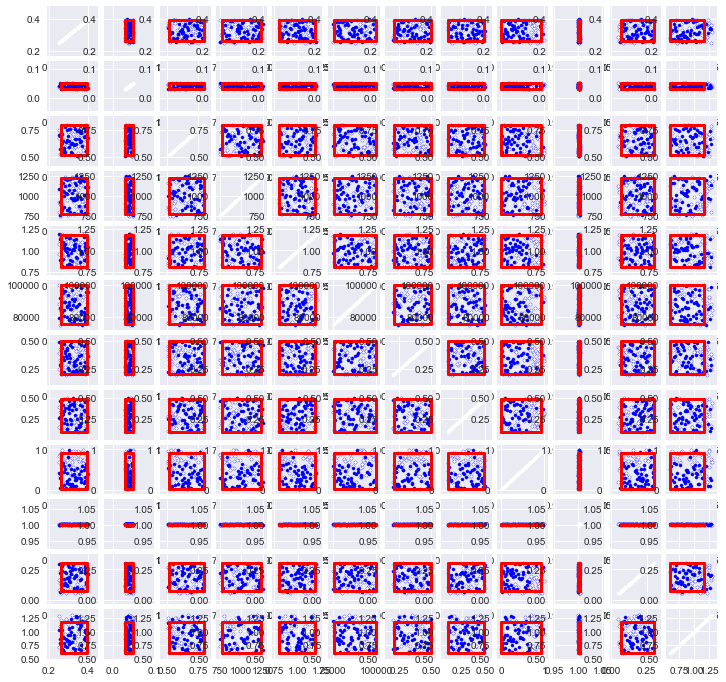

In [51]:
valuebox = 15
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [52]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.6)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 44 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.33, coverage: 0.75, density: 1.0 restricted_dimensions: 9


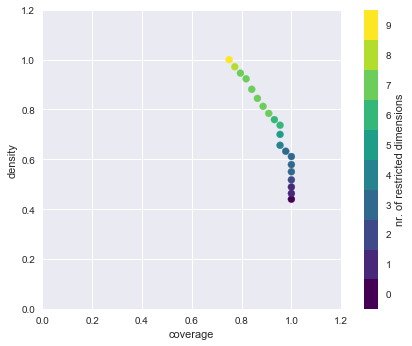

In [53]:
box_1.show_tradeoff()

coverage    0.795455
density     0.945946
mass            0.37
mean        0.945946
res dim            7
Name: 17, dtype: object

                                      box 17               \
                                         min          max   
PopFracInteg                        0.302022     0.990250   
Extensive Shrimp Survival Rate      0.136056     0.397637   
MinWage                          5040.393127  9592.295618   
Freshwater Shrimp Survival Rate     0.229951     0.469258   
Intensive Shrimp Survival Rate      0.718002     0.963583   
FloodDuration                       0.101049     0.928681   
ExogNutAvailRate                    8.048871    14.573975   

                                                                              
                                                                   qp values  
PopFracInteg                                         [0.0072142194780505514]  
Extensive Shrimp Survival Rate                        [0.085573294861767193]  
MinW

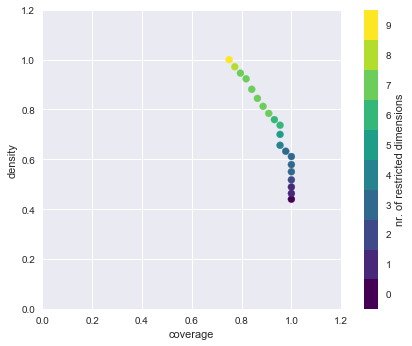

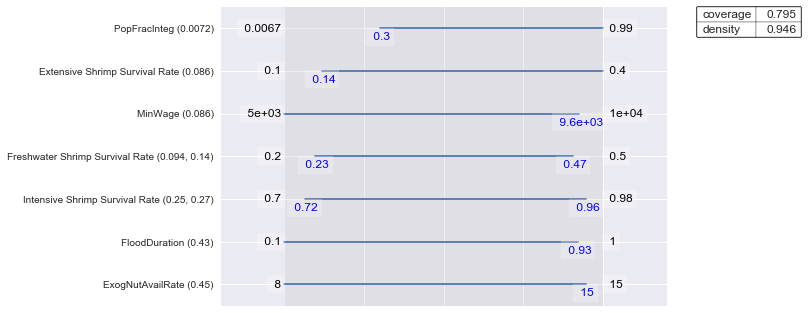

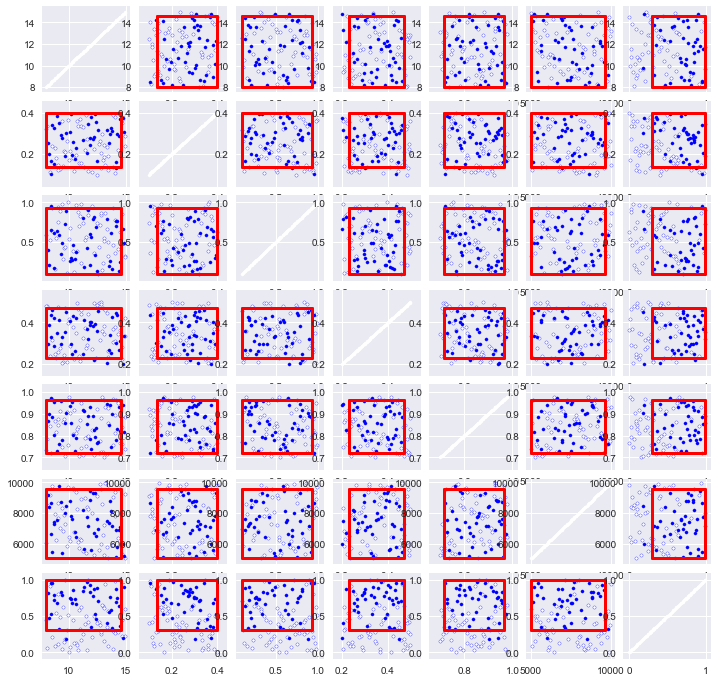

In [54]:
valuebox = 17
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [65]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.232] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 62 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.42, coverage: 0.6774193548387096, density: 1.0 restricted_dimensions: 8


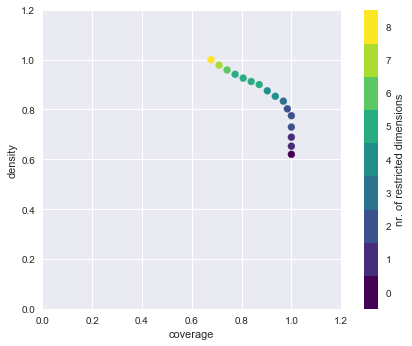

In [66]:
box_1.show_tradeoff()
# mpld3.display()

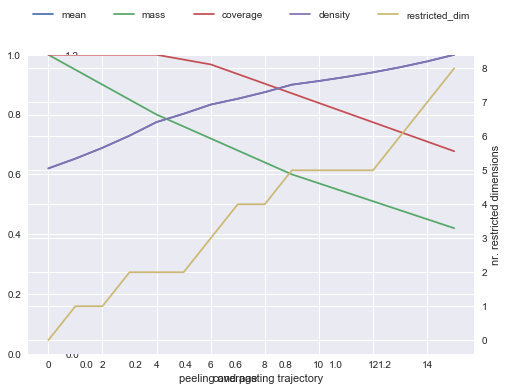

In [67]:
box_1.show_ppt()
plt.show()

coverage    0.774194
density     0.941176
mass            0.51
mean        0.941176
res dim            5
Name: 12, dtype: object

                                  box 12                                 
                                     min       max              qp values
Extensive Shrimp Survival Rate  0.150773  0.397637  [0.05444325774474832]
PopFracInteg                    0.006704  0.870222  [0.09669896979110458]
Extense Selling                 4.192411  7.982966  [0.10476774485706747]
ExtShrimpFarmArea               0.857494  1.196733   [0.2129953831767134]
crop survival probability       0.067492  0.299023  [0.29313945031044852]



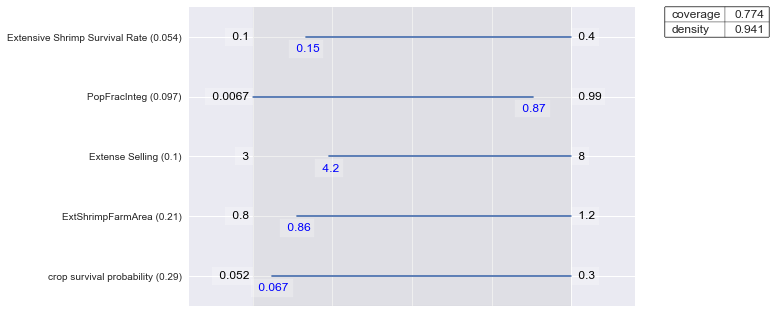

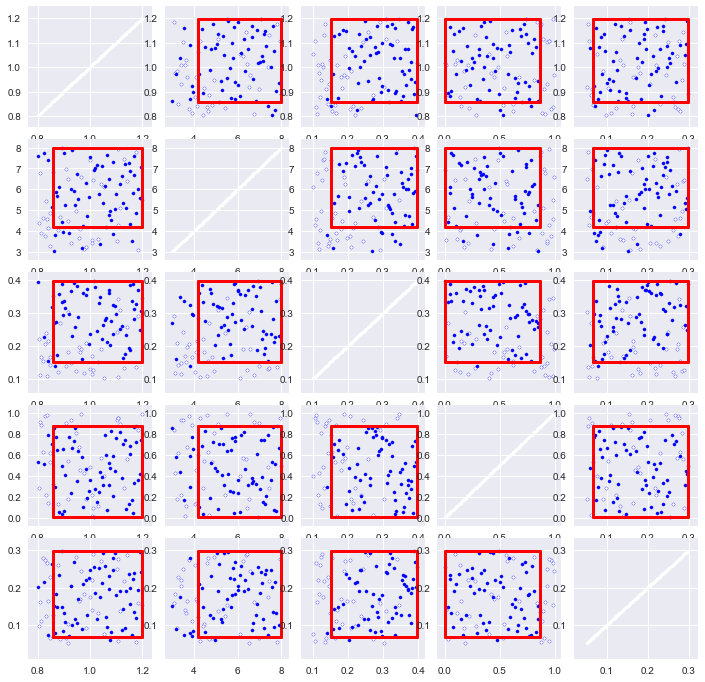

In [68]:
valuebox = 12
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [70]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<200] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 85 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.68, coverage: 0.8, density: 1.0 restricted_dimensions: 4


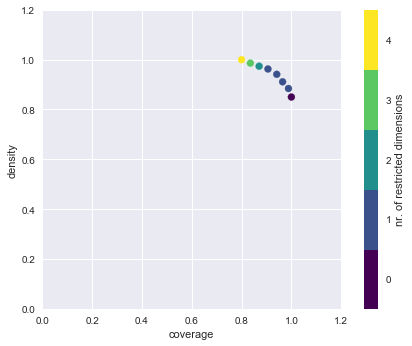

In [71]:
box_2.show_tradeoff()
# mpld3.display()

coverage     0.8
density        1
mass        0.68
mean           1
res dim        4
Name: 7, dtype: object

                      box 7                                    
                        min       max                 qp values
FloodDuration      0.101049  0.819677  [0.00022357826957666239]
ExtShrimpFarmArea  0.818371  1.196733     [0.38632957433917658]
Extense Selling    3.003462  7.749862     [0.38632957433917658]
FertPriceChngRate  1.012083  1.049730     [0.38632957433917658]



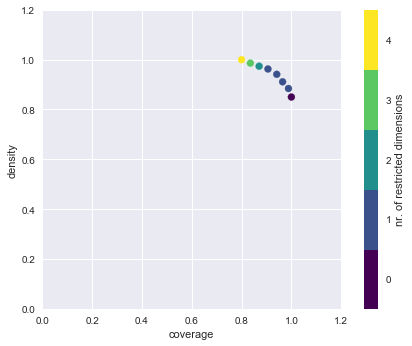

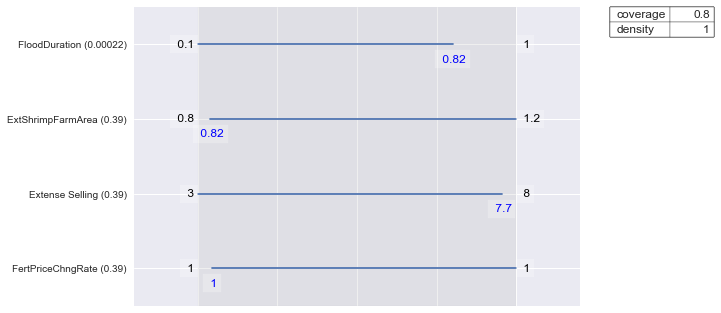

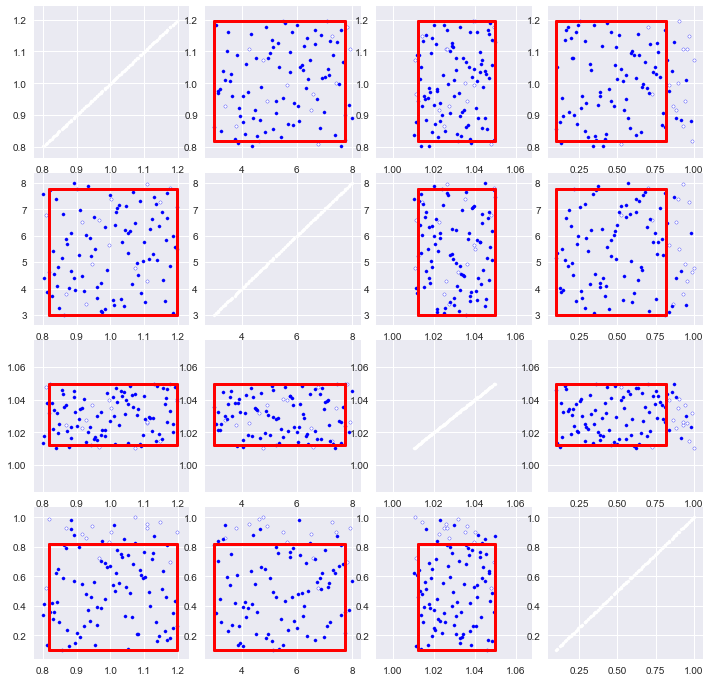

In [72]:
valuebox = 7
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

# Integrated Model

In [15]:
vensimModel = VensimModel("BaseCaseInteg", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand_up.vpm" )

In [16]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
            RealParameter("PopFracExtensive", 0, 1),
            RealParameter("PopFracInteg", 0, 1)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [17]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [18]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_integ_norand_up.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_integ_norand_up.tar.gz


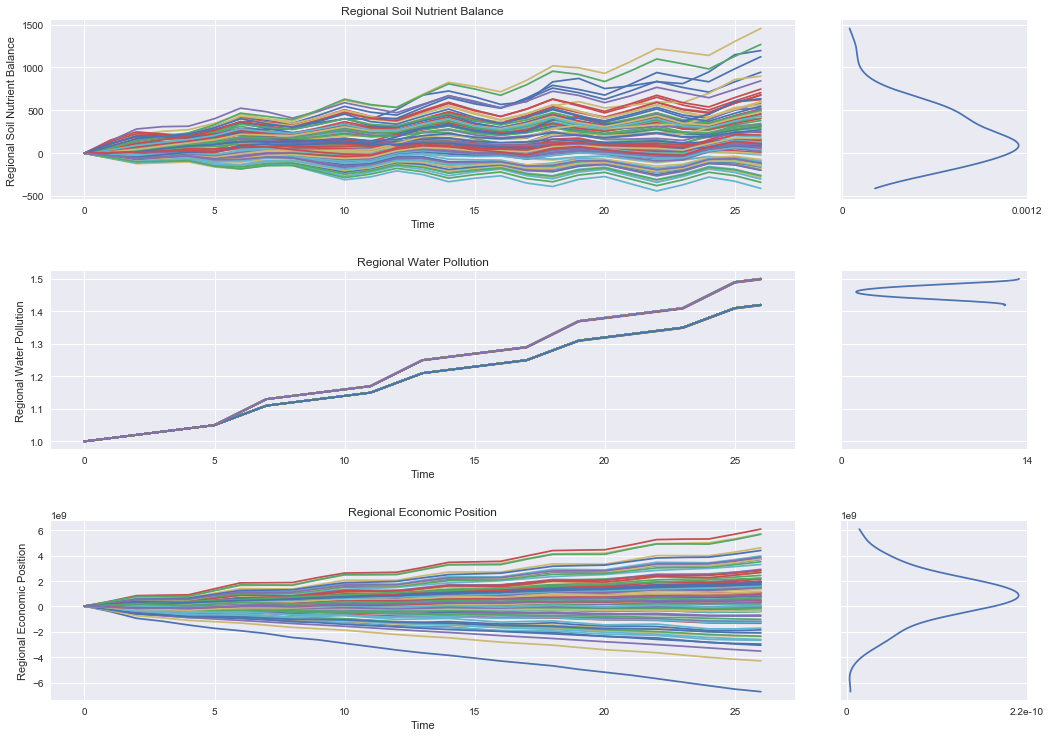

In [19]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [101]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_integ_norand_up.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_integ_norand_up.tar.gz


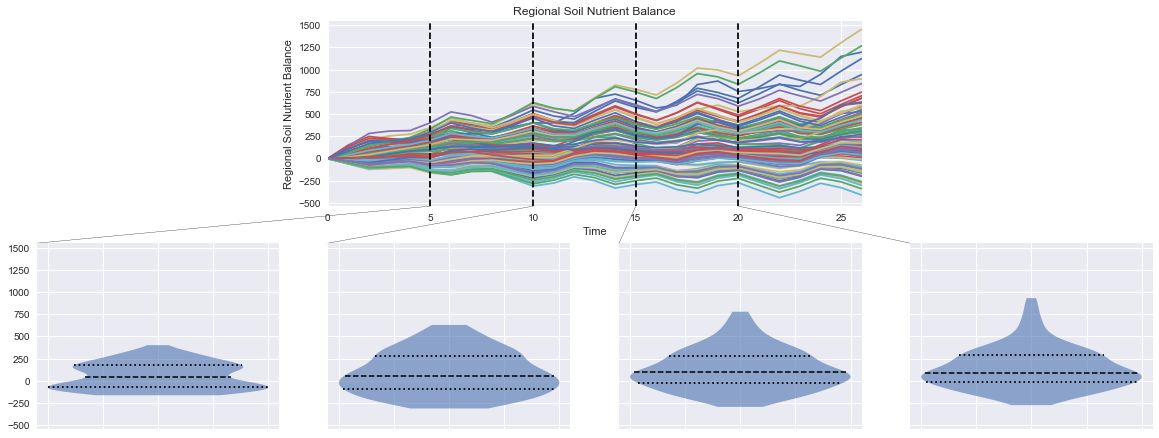

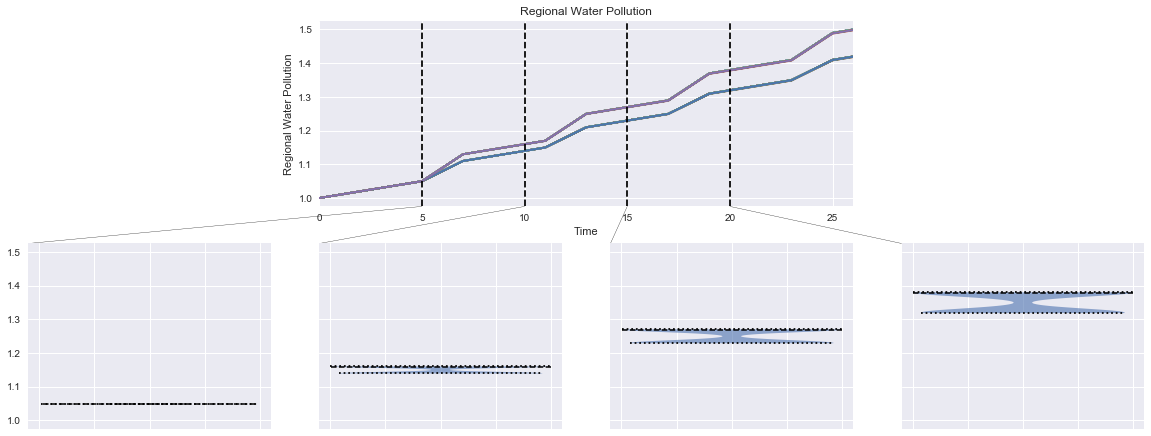

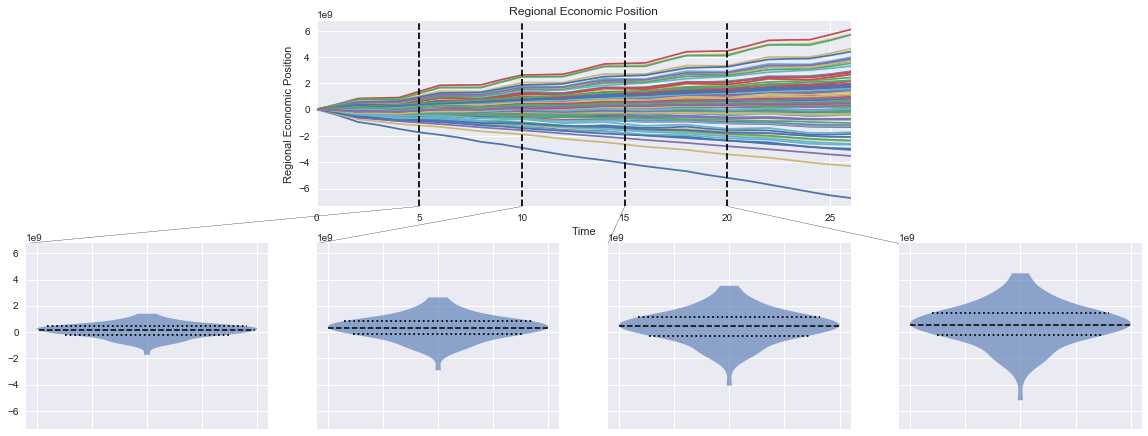

In [102]:
fig = emaplt.multiple_densities(results, points_in_time=[5, 10, 15, 20], 
                                outcomes_to_show=['Regional Soil Nutrient Balance','Regional Water Pollution','Regional Economic Position'], density=u'violin', plot_type = 'lines')
# plt.rcParams["figure.figsize"] = (5,15)
plt.show()

In [74]:
experiments, outcomes= results

In [75]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 32 cases of interest
[MainProcess/INFO] mean: 0.9655172413793104, mass: 0.29, coverage: 0.875, density: 0.9655172413793104 restricted_dimensions: 16


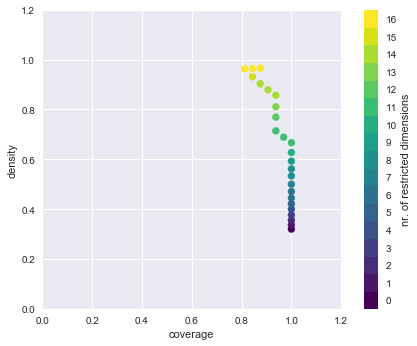

In [76]:
box_1.show_tradeoff()
# mpld3.display()

coverage      0.8125
density     0.962963
mass            0.27
mean        0.962963
res dim           16
Name: 22, dtype: object

                                                 box 22                \
                                                    min           max   
MaxNutReqPerHectare                          458.189525  5.499446e+02   
PopFracExtensive                               0.005343  8.790148e-01   
PopFracInteg                                   0.003757  8.184556e-01   
CostIntense                                    0.731191  9.984160e-01   
BackupFraction                                 1.077544  1.299047e+00   
Dredging cost                                769.068391  1.247079e+03   
FertStartPrice                                 3.396234  6.965572e+00   
CostFresh                                      0.501977  7.861512e-01   
ExogNutAvailRate                               8.064312  1.458737e+01   
Salinity Fluctuation Intensity                 3.028449  6.612318e+

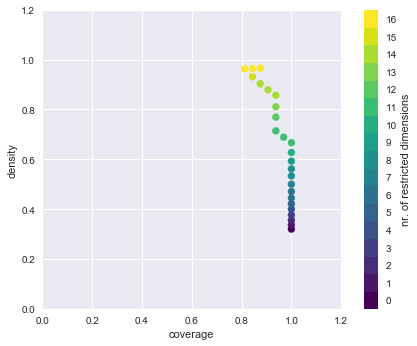

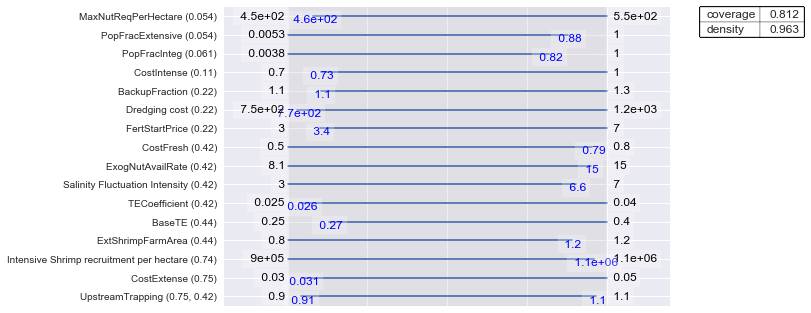

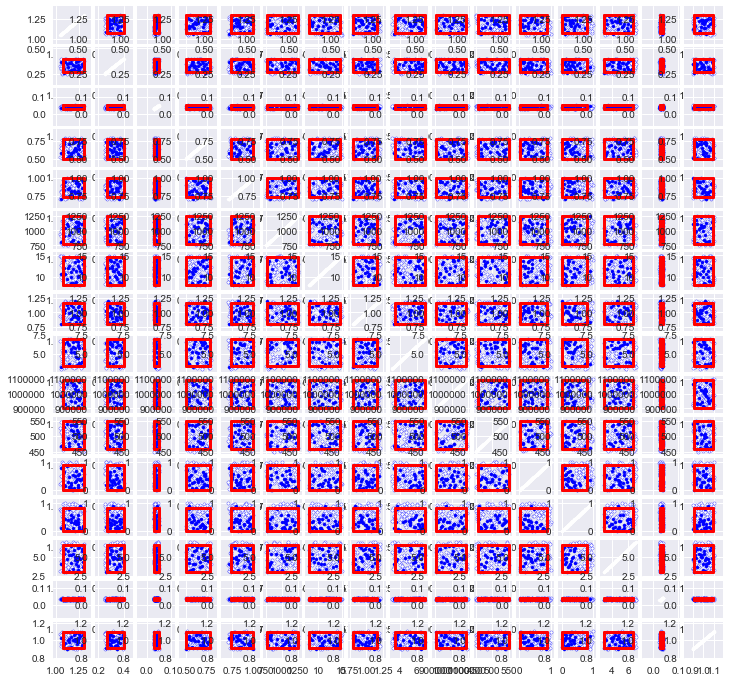

In [78]:
valuebox = 22
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [79]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.6)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 68 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.42, coverage: 0.6176470588235294, density: 1.0 restricted_dimensions: 6


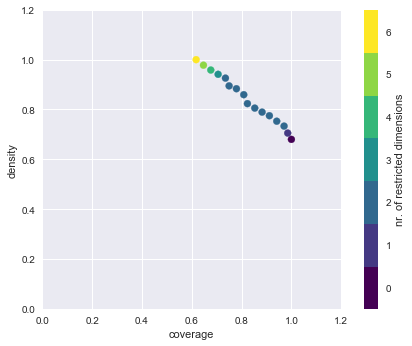

In [80]:
box_1.show_tradeoff()

coverage    0.676471
density     0.958333
mass            0.48
mean        0.958333
res dim            4
Name: 13, dtype: object

                                     box 13               \
                                        min          max   
PopFracInteg                       0.442871     0.997132   
Freshwater Shrimp Survival Rate    0.200817     0.485050   
CostIntense                        0.700334     0.985026   
Dredging cost                    754.551246  1227.715366   

                                                          
                                               qp values  
PopFracInteg                     [1.765999872562528e-05]  
Freshwater Shrimp Survival Rate    [0.44425622718994717]  
CostIntense                        [0.45794491712501295]  
Dredging cost                      [0.45794491712501295]  



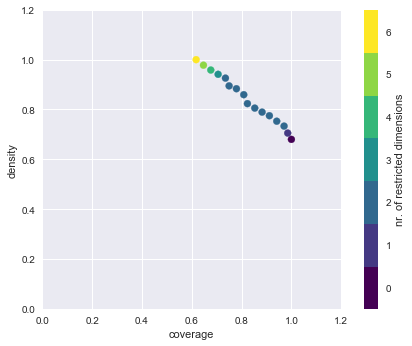

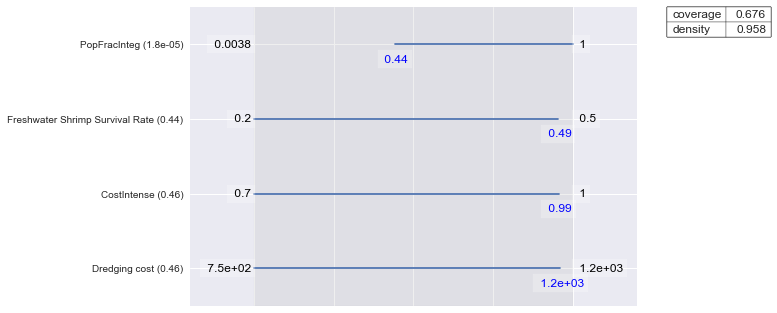

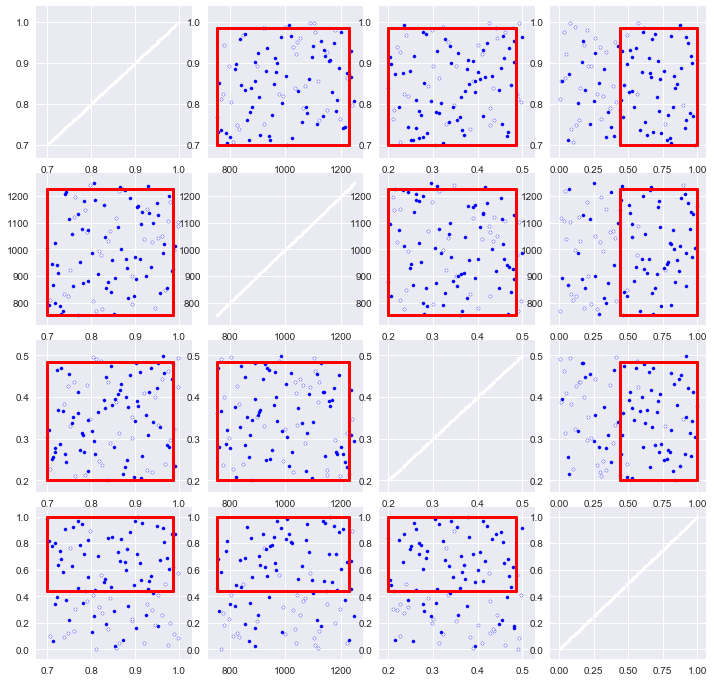

In [81]:
valuebox = 13
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [83]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.227] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 52 cases of interest
[MainProcess/INFO] mean: 0.975609756097561, mass: 0.41, coverage: 0.7692307692307693, density: 0.975609756097561 restricted_dimensions: 8


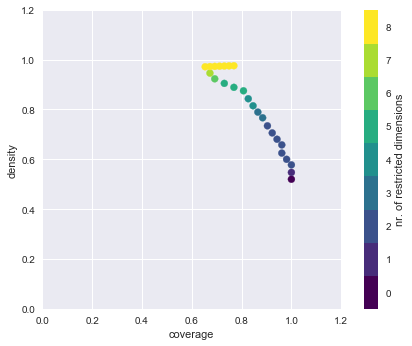

In [84]:
box_1.show_tradeoff()
# mpld3.display()

coverage    0.769231
density     0.888889
mass            0.45
mean        0.888889
res dim            5
Name: 14, dtype: object

                                                 box 14                \
                                                    min           max   
PopFracExtensive                               0.005343      0.728336   
PopFracInteg                                   0.003757      0.838903   
IntenShrimpFarmArea                            0.101912      0.466348   
Dredging cost                                769.068391   1207.515376   
Freshwater Shrimp Recruitment per hectare  10601.403924  24124.034857   

                                                                                       
                                                                            qp values  
PopFracExtensive                                              [0.0025692483432851543]  
PopFracInteg                                                   [0.017943462074651684]  
IntenS

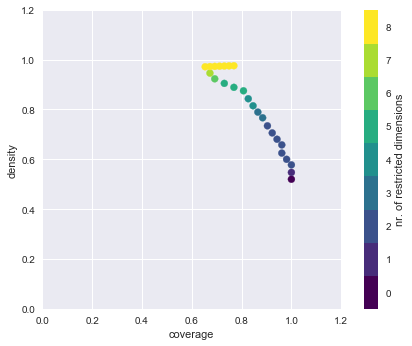

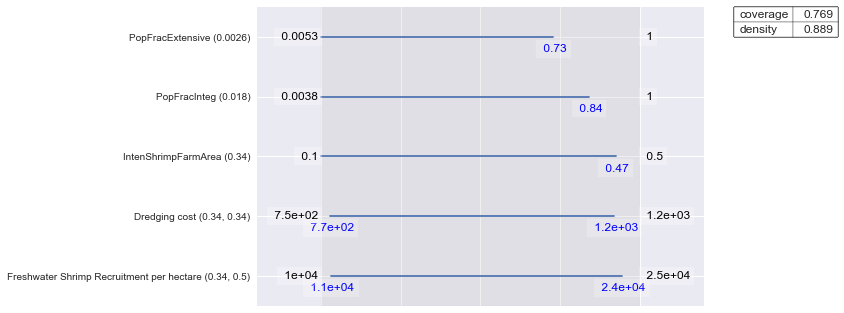

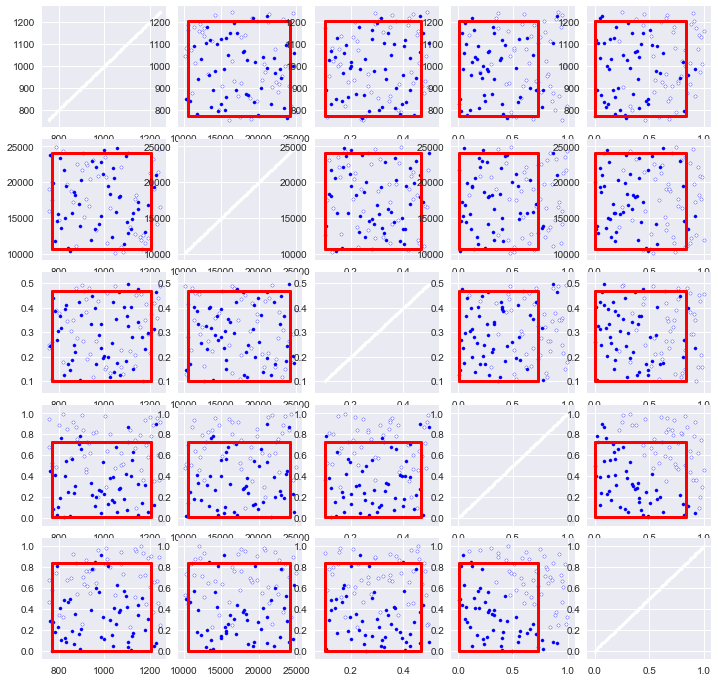

In [85]:
valuebox = 14
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [88]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<100] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 53 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.39, coverage: 0.7358490566037735, density: 1.0 restricted_dimensions: 6


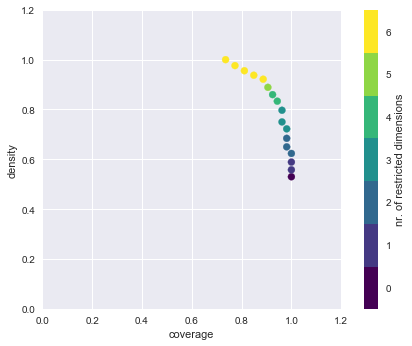

In [89]:
box_2.show_tradeoff()
# mpld3.display()

coverage    0.849057
density       0.9375
mass            0.48
mean          0.9375
res dim            6
Name: 13, dtype: object

                                                 box 13                \
                                                    min           max   
FloodDuration                                  0.106916  7.525877e-01   
PopFracInteg                                   0.003757  8.709939e-01   
TECoefficient                                  0.025727  3.997752e-02   
Intensive Shrimp recruitment per hectare  909861.719039  1.099836e+06   
SedNutContent                                274.063865  3.297606e+02   
CostRiceUnit                                   1.678046  7.617958e+00   

                                                                                     
                                                                          qp values  
FloodDuration                                              [0.00096295427403052573]  
PopFracInteg               

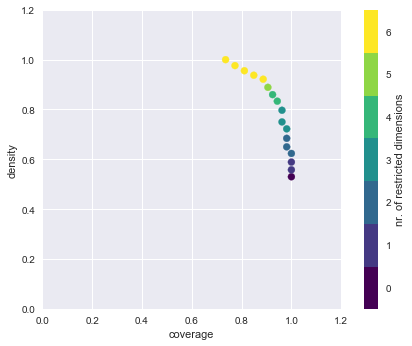

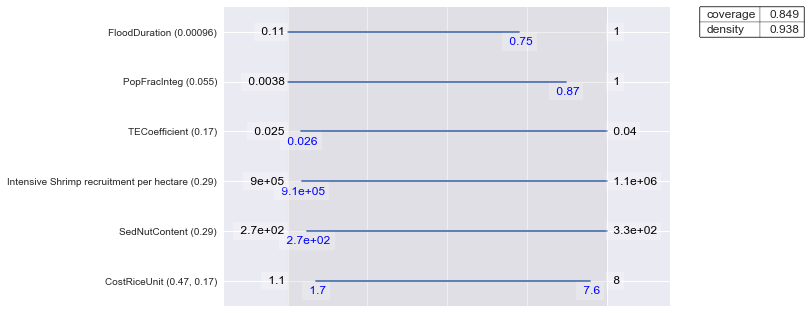

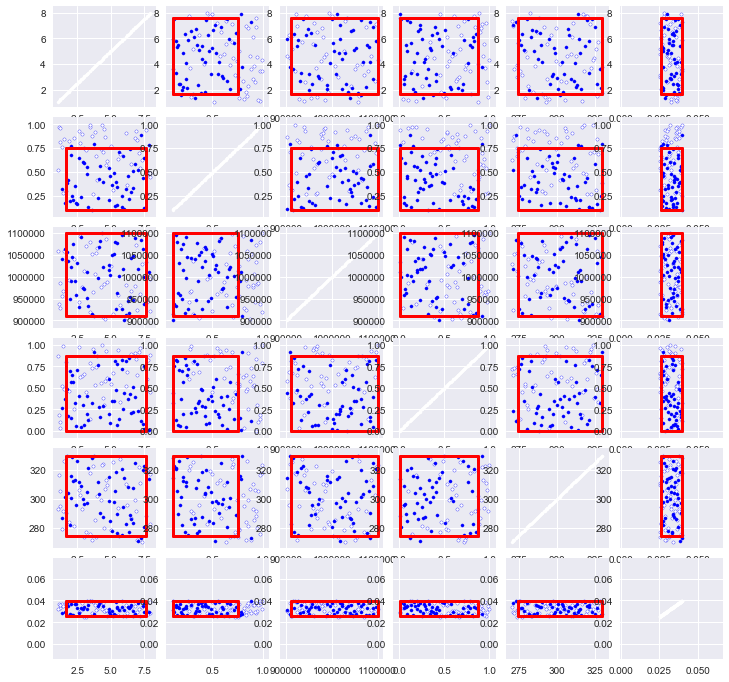

In [90]:
valuebox = 13
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

###  without government intervention, none of the model is compeletely sustainable. These models do not account for government interventions to reduce salinity intrusion, subisdies provided to farmers for integrated models, value creation through training. 

The Model is exposed to increasing uncertainties about salinity, no control over crop failure and market price fluctuations that can affect the selling price of the products. Furthermore, this model does not consider the possibilities of government on waste water treatment which affects the survival rate of shrimp, if farmers don't make invetsments for necessary cleaning infrastructure. 
One insight that can be drawn from all the 3 models is that diversification seems to be the best strategy (even though majority of the outcomes have negative economic position.

Further step is to explore the scenarios which influence the targets, and policy structures will be implemented. Furthermore, time slices will be created to see the short term effects of those policies. 


Maladaptive space critique - 

There may be a case where a strategy may be maladpative inn the shorter duration cycle but may become viable in the longer run. This is very counterintuitive and will be elaborated later with a detailed example.